# Análise de Dados - UFPB

# Mini Projeto 4 - Banco de dados jogos da Steam
Usaremos os dados dos jogos da *Steam* para entender os fatores que influenciam na popularidade e compradores dos jogos usando modelos de regressão e outras análises estatísticas. Os dados que combinam informações de preços, data de lançamento, gêneros, notas dos jogos e etc estão no arquivo `dados/games.zip`.

## 0. Carregamento dos dados e bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

ja_rodou = False

dados = pd.read_csv('dados/games.zip')
pd.set_option('display.max_columns', None)
sns.set_theme()
plt.rcdefaults()

# 1. Tratamento dos dados

Para melhorar a eficiência da nossa análise dos dados, iremos remover colunas e jogos que não interessam para esta análise.


## 1.1 Removendo jogos e colunas do dataset

Aqui iremos filtrar os dados afim de nos livrarmos de informações desnecessárias para a análise.

In [2]:
print(f'Total de colunas:{len(dados.columns)} ')
dados = dados[dados["Median playtime forever"] > 5]
dados.fillna(0)

# Colunas Reviews aparenta ter apenas NaN
# Vamos usar os jogos que possuem apenas mais de 20 horas jogadas para essa analise?

if ja_rodou == False:
    excluir = ['AppID','Support url', 'Movies', 'Screenshots', 'About the game', 'Website', 'Support email', 
               'Reviews', 'Metacritic url', 'Header image', 'Tags','Recommendations','Notes', 
               'User score','Average playtime two weeks', 'Median playtime two weeks','Windows',
                'Mac', 'Linux','Required age','DLC count','Score rank', 'Achievements']
    dados = dados.drop(columns=excluir)
    ja_rodou = True

print(f'Total de colunas depois de excluir: {len(dados.columns)}')

renomear_colunas = ['Nome', 'Data_lançamento', 'Quantidade_Compradores', 'Pico_jogadores', 'Preço_Dolar', 'Linguas_suportadas',
       'Dublagem_completa', 'Nota_Metacritic', 'Positivo', 'Negativo', 'Tempo_medio_sempre', 'Mediana_tempo_jogo', 'Desenvolvedores', 'Editores', 'Categorias',
       'Generos']
dados.columns = renomear_colunas
dados = dados[dados['Nota_Metacritic'] > 0]
dados = dados[dados['Pico_jogadores'] > 0]
dados = dados[dados['Positivo'] > 0]
dados = dados[dados['Negativo'] > 0]

Total de colunas:39 
Total de colunas depois de excluir: 16


Inicialmente removemos jogos que possuissem um tempo médio de jogatina menor que 5 horas, logo em seguida preferimos remover colunas com informações desnecessárias para a análise. Renomeamos todas as colunas para o idioma português, afim de ter um melhor entendimento dos dados, também decidimos que jogos que possuissem uma nota no Metacritic, pico de jogadores, quantidade de avaliações positivas e negativas iguais a 0 seriam removidos do dataset.

In [3]:

def contar_dublagens(lista):
    return lista.count("'") // 2

dados["Total_votos"] = dados["Positivo"] + dados["Negativo"]
dados.insert(dados.columns.get_loc("Negativo") + 1, "Total_votos", dados.pop("Total_votos"))

dados['Num_linguagens'] = dados['Linguas_suportadas'].str.count(',') + 1
dados.insert(dados.columns.get_loc("Linguas_suportadas") + 1, "Num_linguagens", dados.pop("Num_linguagens"))

dados['Quantidade_Compradores'] = dados['Quantidade_Compradores'].apply(lambda x: tuple(map(int, x.split(' - '))))
dados['Min'] = dados['Quantidade_Compradores'].apply(lambda x: x[0])
dados['Max'] = dados['Quantidade_Compradores'].apply(lambda x: x[1])
dados['Quantidade_Compradores'] = (dados['Min'] + dados['Max']) / 2


dados['Num_dublagens'] = dados['Dublagem_completa'].apply(contar_dublagens)
dados.insert(dados.columns.get_loc("Dublagem_completa") + 1, "Num_dublagens", dados.pop("Num_dublagens"))

dados = dados.drop(columns=['Min','Max'])

In [4]:
dados['Data_lançamento'] = pd.to_datetime(dados['Data_lançamento'], format='mixed')
dados['Mes'] = dados['Data_lançamento'].dt.to_period('M')
dados['Ano'] = dados['Data_lançamento'].dt.to_period('Y')

Criamos novas colunas que servem para contar a quantidade de idiomas suportados, quantidade de dublagens dos jogos. Além de consertar as colunas *Quantidade_Compradores* e *Data_lançamento* para que nos dessem informações úteis para análise, ao final foi criadas colunas para regitrar o mês e o ano de lançamento de cada jogo para análises futuras.



# 2. Análise Exploratoria

Aqui faremos a análise exploratória dos dados afim de averiguar suas características que mais nos interesssam.


## 2.1 Análise por Desenvoledor

### 2.1.1 Quais os desenvolvedores com mais jogos?

In [5]:
jogos_por_desenvolvedor = dados['Desenvolvedores'].value_counts()
jogos_por_desenvolvedor = jogos_por_desenvolvedor.to_frame()
jogos_por_desenvolvedor.columns = ['Jogos por Desenvolvedor']
jogos_por_desenvolvedor.head(5)


,Jogos por Desenvolvedor
Desenvolvedores,
Valve,19
Daedalic Entertainment,16
Ubisoft Montreal,16
Double Fine Productions,15
Nihon Falcom,14


### Gráfico 2.1

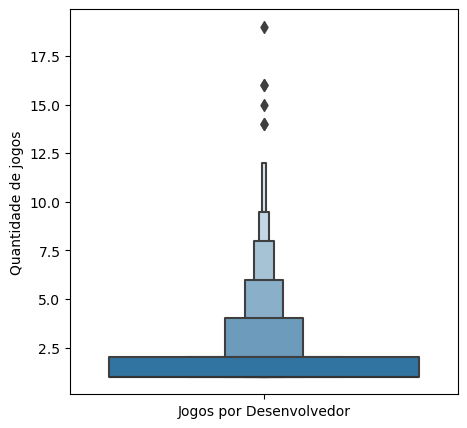

In [6]:
plt.figure(figsize=(5,5))
sns.boxenplot(jogos_por_desenvolvedor)
plt.ylabel('Quantidade de jogos')
plt.show()

O *Gráfico 2.1* nos mostra que a maioria dos desenvolvedores fizeram apenas de 1 a 2 jogos, enquanto poucos se arriscam a produzir mais de 7.

### 2.1.2 Quais os desenvolvedores com melhores avaliações?

In [7]:
nota_media_jogo_desenvolvedor = dados.groupby('Desenvolvedores')["Nota_Metacritic"].mean()
nota_media_jogo_desenvolvedor = nota_media_jogo_desenvolvedor.to_frame().sort_values(by='Nota_Metacritic', ascending=False)
nota_media_jogo_desenvolvedor.head(5)

,Nota_Metacritic
Desenvolvedores,
ZA/UM,97.0
"2K Boston,2K Australia",96.0
"Irrational Games,Virtual Programming (Linux)",94.0
"id Software,Nightdive Studios,MachineGames",94.0
Bay 12 Games,93.0


#### Gráfico 2.2

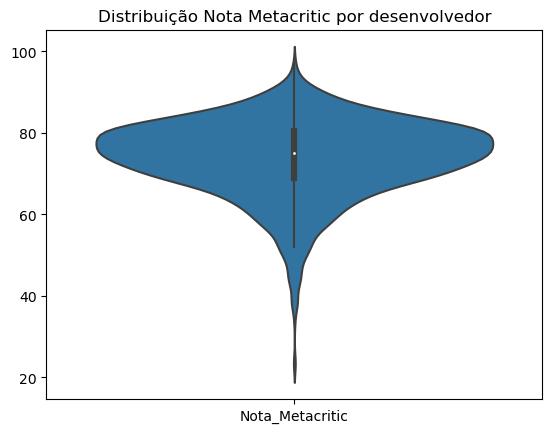

In [8]:
sns.violinplot(nota_media_jogo_desenvolvedor)
plt.title('Distribuição Nota Metacritic por desenvolvedor')
plt.show()

O *Gráfico 2.2* mostra que a maioria das notas Metacritc dos jogos por desenvolvedor estão acomuladas entre 70 e 80, enquanto pouquíssimos desenvovledores possuem uma nota inferior a 70.

## 2.2 Analise por data de lançamento
Nesse subtópico iremos averiguar algumas informações interessantes com base na data de lançamento dos jogos.


### Gráfico 2.3

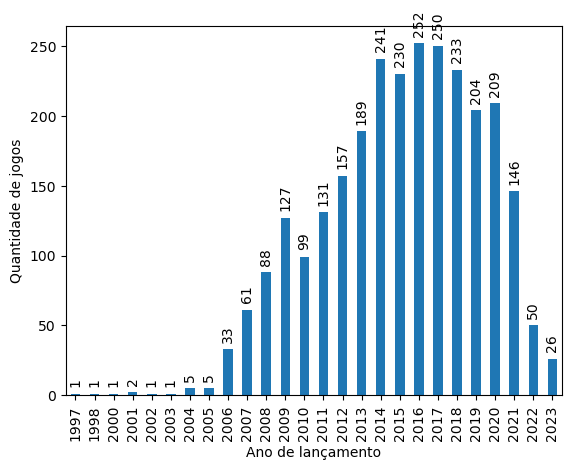

In [9]:
dados_2023_df=dados[dados['Ano']<='2023']

dados_2023=dados_2023_df.groupby('Ano')['Nome'].count()

ax = dados_2023.plot(x='Ano', y='Nome', kind='bar',ylabel="Quantidade de jogos",xlabel="Ano de lançamento")

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(str(height), (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points',rotation='vertical')
plt.show()

O *Gráfico 2.3* representa graficamente a quantidade de jogos lançados na steam ao longo dos anos, nele é possível notar que a partir de 2009 teve um crescente número de lançamentos em comparação com os anos anteriores. Como foi visto anteriormente o dataset teve seus dados tratados para que fossem removidos jogos que não atendessem a certos requisitos, mas acredito que se eles ainda estivessem presentes, teríamos um crescimento exponencial no lançamento dos jogos entre 2009 e 2019, tendo uma redução no ano de 2020 devido à pandemia, devido a uma série de adiamentos de jogos que iriam ser lançados.

Fonte: https://meups.com.br/noticias/devs-precisaram-adiar-seus-games-pandemia/

### Gráfico 2.4

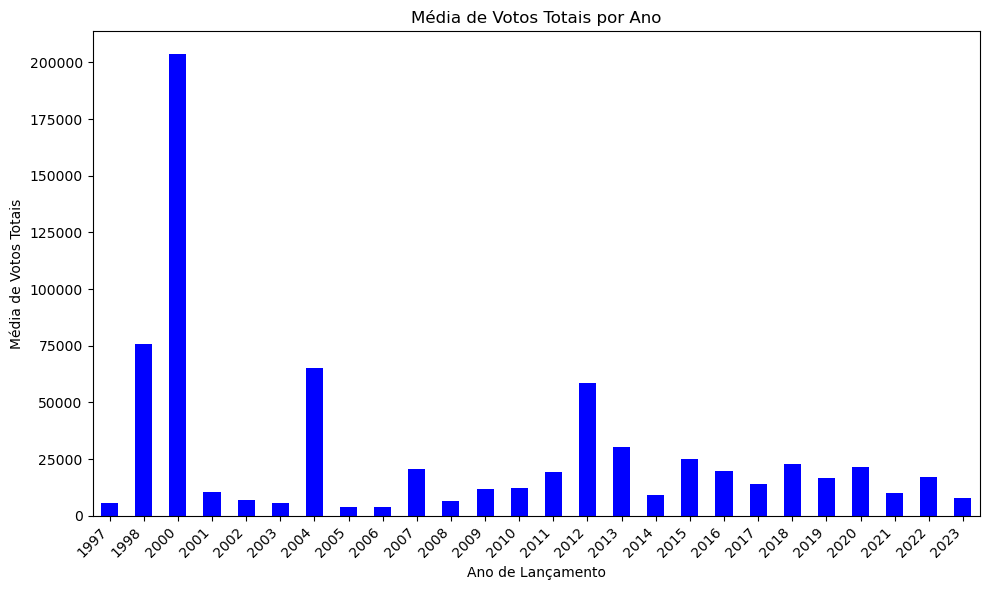

In [10]:
media_votos_por_ano = dados.groupby('Ano')['Total_votos'].mean()
plt.figure(figsize=(10, 6))
media_votos_por_ano.plot(kind='bar', color='blue')

plt.xlabel('Ano de Lançamento')
plt.ylabel('Média de Votos Totais')
plt.title('Média de Votos Totais por Ano')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

O *Gráfico 2.4* representa a destribuição da média total de avaliações recebidas pelos jogos ao longo dos anos, nele é possível notar que os anos de 1998, 2000, 2004 e 2012 se destacam quando o assunto é quantidade média de avaliações recebidas, o que indica que os jogos destes anos são mais populares que o resto.

## 2.3 Medidas de centralidade e dispersão dos jogos
Aqui trataremos de observar as medidas de centralidade e dispersão das colunas que mais nos chamou a atenção, afim de perceber quão dispersos são os dados dessas colunas.

### 2.2.1 Medidas de centralidade e dispersão por preço

In [11]:
media = dados['Preço_Dolar'].mean()
mediana = dados['Preço_Dolar'].median()
desvio_padrao = dados['Preço_Dolar'].std()
minimo = dados['Preço_Dolar'].min()
maximo = dados['Preço_Dolar'].max()

print("Estatísticas de Centralidade e Dispersão do preço (Dolar) dos jogos")
print(f"Média: {media:.2f}")
print(f"Mediana: {mediana}")
print(f"Desvio Padrão: {desvio_padrao:.2f}")
print(f"Mínimo: {minimo}")
print(f"Máximo: {maximo}")


Estatísticas de Centralidade e Dispersão do preço (Dolar) dos jogos
Média: 16.43
Mediana: 14.99
Desvio Padrão: 12.52
Mínimo: 0.0
Máximo: 69.99


#### Gráfico 2.5

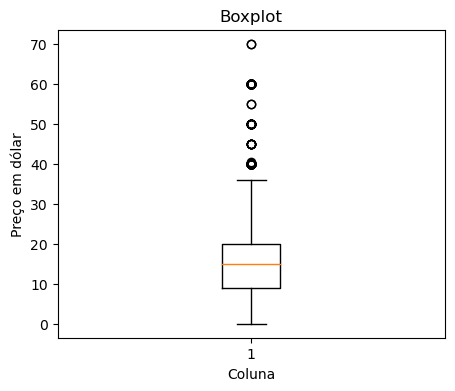

In [12]:
fig, ax = plt.subplots(figsize=(5,4))
ax.boxplot(dados['Preço_Dolar'])
ax.set_xlabel('Coluna')
ax.set_ylabel('Preço em dólar')
ax.set_title('Boxplot')
plt.show()

O *Gráfico 2.5* Demonstra a destribuição dos preços em dólar dos jogos, sendo possível vizualiar que a maioria dos valos dos jogos se concentram entre 8 e 20 dólares, enquanto há algusn outliers com preços acima de 40 dólares.

### 2.2.2 Medidas de centralidade e dispersão por pico de jogadores

In [13]:
media = dados['Pico_jogadores'].mean()
mediana = dados['Pico_jogadores'].median()
desvio_padrao = dados['Pico_jogadores'].std()
minimo = dados['Pico_jogadores'].min()
maximo = dados['Pico_jogadores'].max()

print("Estatísticas de Centralidade e Dispersão do pico jogadores dos jogos")
print(f"Média: {media:.2f}")
print(f"Mediana: {mediana}")
print(f"Desvio Padrão: {desvio_padrao:.2f}")
print(f"Mínimo: {minimo}")
print(f"Máximo: {maximo}")

Estatísticas de Centralidade e Dispersão do pico jogadores dos jogos
Média: 1976.25
Mediana: 20.0
Desvio Padrão: 26523.41
Mínimo: 1
Máximo: 872138


#### Gráfico 2.6

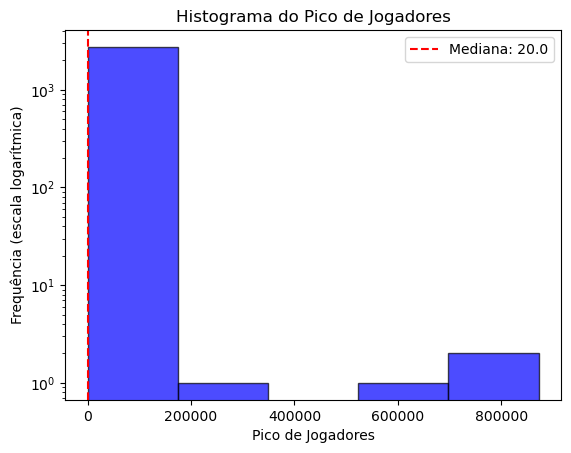

In [14]:
df = pd.DataFrame(dados)
mediana_pico_jogadores = df["Pico_jogadores"].median()

plt.hist(df["Pico_jogadores"], bins=5, alpha=0.7, color='blue', edgecolor='black', log=True)
plt.axvline(mediana_pico_jogadores, color='red', linestyle='--', label=f"Mediana: {mediana_pico_jogadores}")
plt.xlabel('Pico de Jogadores')
plt.ylabel('Frequência (escala logarítmica)')
plt.title('Histograma do Pico de Jogadores')
plt.legend()
plt.show()

O *Gráfico 2.6* representa a frequência que os jogos conseguem alcançar certas quantidades de pico de jogadores, a partir dele podemos perceber que milhares de jogos possuem um pico de jogadores entre 0 e 190.000, enquanto poucas jogos conseguem passar disso.

#### 2.2.2.1 Jogos que possuem pico de jogadores acima de 90K
Abaixo estão os jogos que conseguiram bater um pico de jogadores simultâneos acima de 190K.

In [15]:
picoJogadores = dados[dados['Pico_jogadores']>190000]
picoJogadores

,Nome,Data_lançamento,Quantidade_Compradores,Pico_jogadores,Preço_Dolar,Linguas_suportadas,Num_linguagens,Dublagem_completa,Num_dublagens,Nota_Metacritic,Positivo,Negativo,Total_votos,Tempo_medio_sempre,Mediana_tempo_jogo,Desenvolvedores,Editores,Categorias,Generos,Mes,Ano
736,Apex Legends™,2020-11-04,35000000.0,235067,0.00,"['English', 'French', 'Italian', 'German', 'Sp...",13,"['English', 'French', 'Italian', 'German', 'Sp...",11,88,415524,66608,482132,6388,904,Respawn Entertainment,Electronic Arts,"Multi-player,PvP,Online PvP,Co-op,Online Co-op...","Action,Adventure,Free to Play",2020-11,2020
17585,Dota 2,2013-07-09,150000000.0,558759,0.00,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...",28,"['English', 'Korean', 'Simplified Chinese', 'V...",4,90,1477153,300437,1777590,37162,880,Valve,Valve,"Multi-player,Co-op,Steam Trading Cards,Steam W...","Action,Free to Play,Strategy",2013-07,2013
46158,Counter-Strike: Global Offensive,2012-08-21,75000000.0,825215,0.00,"['Czech', 'Danish', 'Dutch', 'English', 'Finni...",28,"['English', 'Vietnamese']",2,83,5764420,766677,6531097,30484,6357,"Valve,Hidden Path Entertainment",Valve,"Multi-player,Steam Achievements,Full controlle...","Action,Free to Play",2012-08,2012
69429,Hogwarts Legacy,2023-02-10,7500000.0,872138,59.99,"['English', 'French', 'Italian', 'German', 'Sp...",14,"['English', 'French', 'Italian', 'German', 'Sp...",9,84,33521,2000,35521,661,501,Avalanche Software,Warner Bros. Games,"Single-player,Steam Achievements,Full controll...","Action,Adventure,RPG",2023-02,2023


### 2.2.3 Medidas de centralidade e dispersão por nota metacritic

In [16]:
media = dados['Nota_Metacritic'].mean()
mediana = dados['Nota_Metacritic'].median()
desvio_padrao = dados['Nota_Metacritic'].std()
minimo = dados['Nota_Metacritic'].min()
maximo = dados['Nota_Metacritic'].max()

print("Estatísticas de Centralidade e Dispersão das notas metacritic dos jogos")
print(f"Média: {media:.2f}")
print(f"Mediana: {mediana}")
print(f"Desvio Padrão: {desvio_padrao:.2f}")
print(f"Mínimo: {minimo}")
print(f"Máximo: {maximo}")

Estatísticas de Centralidade e Dispersão das notas metacritic dos jogos
Média: 74.70
Mediana: 76.0
Desvio Padrão: 9.57
Mínimo: 23
Máximo: 97


#### Gráfico 2.7

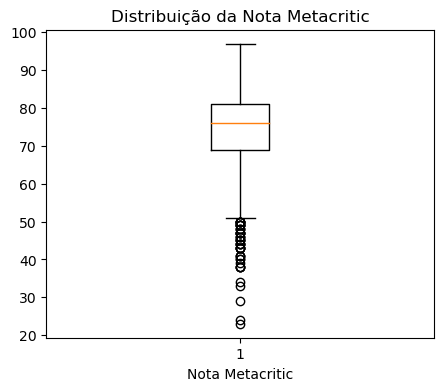

In [17]:
plt.figure(figsize=(5,4))
plt.boxplot(dados['Nota_Metacritic'])
plt.title('Distribuição da Nota Metacritic')
plt.xlabel('Nota Metacritic')
plt.show()

O *Gráfico 2.7* demonstra gaficamente a destribuição de notas Metacritic dos jogos, nele é notório que a maior parte das notas se concentram entre 70 e 80, enquanto muitos outliers possuem notas abaixo de 50.

## 2.4 Analisando a dublagem dos jogos

Aqui iremos observar se jogos que possuem dublagem são mais atrativos para o público geral;

### 2.4.1 Comparando a média de popularidade dos jogos dublados e sem dublagem
Aqui prentendemos saber se jogos dublados são ou não mais populares que jogos sem dublagem.

In [18]:
jogosDublados = dados[dados['Num_dublagens'] > 0]
jogosSemDublagem = dados[dados['Num_dublagens'] == 0]
media_dublados = jogosDublados['Total_votos'].mean() / 1_000
media_sem_dublagem = jogosSemDublagem['Total_votos'].mean() / 1_000

#### Gráfico 2.8

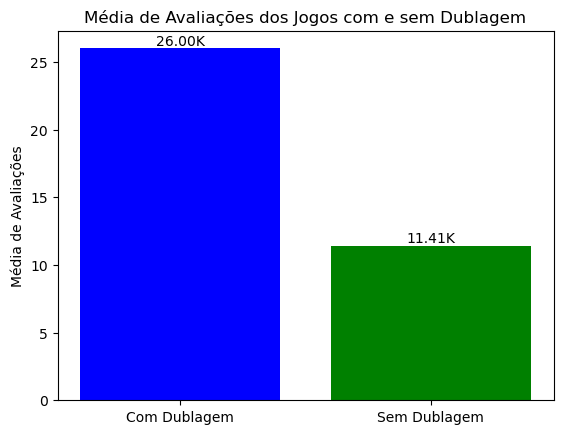

In [19]:
plt.bar(['Com Dublagem', 'Sem Dublagem'], [media_dublados, media_sem_dublagem], color=['blue', 'green'])
plt.title('Média de Avaliações dos Jogos com e sem Dublagem')
plt.ylabel('Média de Avaliações')
plt.text(0, media_dublados, "{:.2f}K".format(media_dublados), ha='center', va='bottom')
plt.text(1, media_sem_dublagem, "{:.2f}K".format(media_sem_dublagem), ha='center', va='bottom')
plt.show()

É notório que jogos com dublagens são muito mais populares que os jogos sem dublagem, como podemos vê no *Gráfico 2.8*, jogos dublados possuem mais que o dobro da média de avaliações dos jogos sem dublagem.

### 2.4.2 Comparando a média de compradores de jogos dublados e sem dublagens
Aqui pretendemos saber se jogos dublados possuem uma tendência maior a serem consumidos do que os jogos sem dublagem.

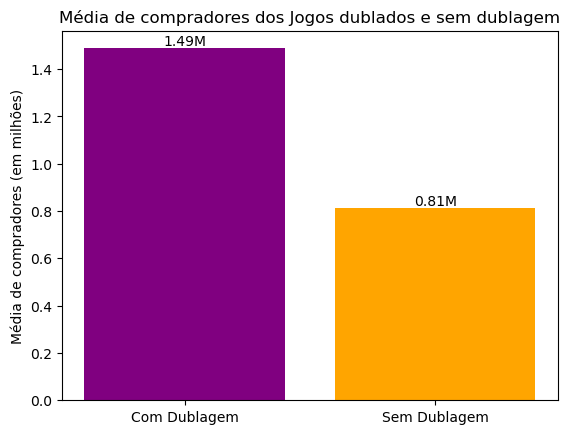

In [20]:
media_dublados = jogosDublados['Quantidade_Compradores'].mean()  / 1_000_000
media_sem_dublagem = jogosSemDublagem['Quantidade_Compradores'].mean() / 1_000_000

plt.bar(['Com Dublagem', 'Sem Dublagem'], [media_dublados, media_sem_dublagem], color=['purple', 'orange'])
plt.title('Média de compradores dos Jogos dublados e sem dublagem')
plt.ylabel('Média de compradores (em milhões)')
plt.text(0, media_dublados, "{:.2f}M".format(media_dublados), ha='center', va='bottom')
plt.text(1, media_sem_dublagem, "{:.2f}M".format(media_sem_dublagem), ha='center', va='bottom')
plt.show()

É perceptível que jogos dublados tendem a serem mais comprados que os sem dublagem, como podemo vê no *Gráfico 2.7*, jogos com dublagem possuem quase o dobro da média de compradores dos jogos sem dublagem.

### 2.4.3 Qual o *top 10* idiomas mais dublados?
Vamos investigar quais os 10 idiomas mais usados para dublar os jogos.

#### Gráfico 2.9

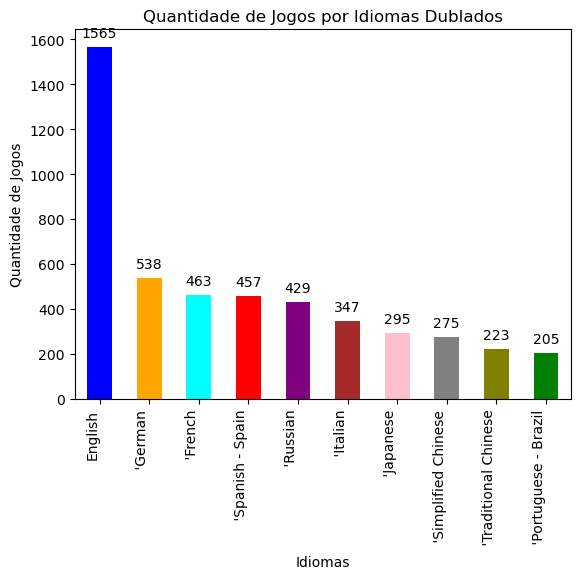

In [21]:
dados['Dublagem_completa'] = dados['Dublagem_completa'].fillna('')
dublagem_separada = dados['Dublagem_completa'].str.split(',')
todas_dublagens = [dublagem.strip("[]'") if dublagem.strip("[]'") else 'Sem dublagem' for sublist in dublagem_separada for dublagem in sublist]
contagem_dublagens = pd.Series(todas_dublagens).value_counts()
contagem_dublagens = contagem_dublagens.drop('Sem dublagem', errors='ignore')
top_10_dublagem = contagem_dublagens.head(10)

cores = ['blue', 'orange', 'cyan', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'green']

ax = top_10_dublagem.plot(kind='bar', color=cores)
ax.set_xlabel('Idiomas')
ax.set_ylabel('Quantidade de Jogos')
ax.set_title('Quantidade de Jogos por Idiomas Dublados')
plt.xticks(rotation=90, ha='right')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.show()

Aqui podemos notar que o idioma mais utilizado para dublar jogos é o inglês, seguido por alemão e francês. Um adendo muito importante o português brasileiro estar presente no *top 10* idiomas mais usados para dublagem, mostrando quão importante é o país no mercado dos jogos.

#### 2.4.3.1 Primeiros jogos dublados em português brasileiro
Examinaremos quais foram os primeiros jogos dublados em PT-BR.

In [22]:
dados_pt_br = dados[dados['Dublagem_completa'].str.contains('Portuguese - Brazil', na=False)]

dados_pt_br.sort_values(by='Ano').head(6)

,Nome,Data_lançamento,Quantidade_Compradores,Pico_jogadores,Preço_Dolar,Linguas_suportadas,Num_linguagens,Dublagem_completa,Num_dublagens,Nota_Metacritic,Positivo,Negativo,Total_votos,Tempo_medio_sempre,Mediana_tempo_jogo,Desenvolvedores,Editores,Categorias,Generos,Mes,Ano
12180,Machinarium,2009-10-16,750000.0,61,14.99,"['English', 'French', 'Italian', 'German', 'Sp...",15,"['English', 'French', 'Italian', 'German', 'Sp...",15,85,10331,482,10813,192,195,Amanita Design,Amanita Design,"Single-player,Steam Achievements,Full controll...","Adventure,Indie",2009-10,2009
53673,Orcs Must Die!,2011-10-11,1500000.0,25,9.99,"['English', 'German', 'French', 'Italian', 'Sp...",9,"['English', 'German', 'French', 'Italian', 'Sp...",9,83,6779,251,7030,373,240,Robot Entertainment,Robot Entertainment,"Single-player,Steam Achievements,Partial Contr...","Action,Indie,Strategy",2011-10,2011
49837,Orcs Must Die! 2,2012-07-30,3500000.0,86,14.99,"['English', 'German', 'French', 'Italian', 'Sp...",9,"['English', 'German', 'French', 'Italian', 'Sp...",9,83,16783,1117,17900,755,360,Robot Entertainment,Robot Entertainment,"Single-player,Multi-player,Co-op,Online Co-op,...","Action,Adventure,Indie,RPG,Strategy",2012-07,2012
14139,FTL: Faster Than Light,2012-09-14,3500000.0,1768,2.49,"['English', 'French', 'Italian', 'German', 'Sp...",10,"['English', 'French', 'Italian', 'German', 'Sp...",10,84,62214,2684,64898,1787,791,Subset Games,Subset Games,"Single-player,Steam Achievements,Steam Trading...","Indie,Simulation,Strategy",2012-09,2012
16640,Of Orcs And Men,2012-10-11,350000.0,11,14.99,"['English', 'German', 'French', 'Italian', 'Sp...",8,"['English', 'German', 'French', 'Portuguese - ...",4,69,1206,442,1648,563,764,"Cyanide Studio,Spiders","Cyanide Studio,Nacon","Single-player,Steam Achievements,Full controll...","Action,RPG",2012-10,2012
3640,The Witcher 2: Assassins of Kings Enhanced Edi...,2012-04-16,3500000.0,846,19.99,"['English', 'German', 'French', 'Spanish - Spa...",14,"['English', 'German', 'French', 'Russian', 'Po...",6,88,67259,7930,75189,845,314,CD PROJEKT RED,"CD PROJEKT RED,1C-SoftClub","Single-player,Steam Achievements,Steam Trading...",RPG,2012-04,2012


Os primeiros jogos dublados em PT-BR, estranhamente, são jogos bem esquecidos pela maioria dos jogadores, exceto por *The Witcher 2: Assassins of Kings - Enhanced Edition*, que devido a sua sequência bastante popular, inclusive por causa de sua excelente dublagem em PT-BR, acabou se consolidando como um jogo famoso. Fazendo uma análise superficial, pode-se dizer que foi a partir de *The Witcher 2* que as empresas começaram a aderir mais ao mercado brasileiro e começaram a dublar mais os seus jogos.

O *Gráfico 3.0* irá analisar como foi o crescimento no número de dublagens PT-BR ao longo dos anos.

##### Gráfico 3.0

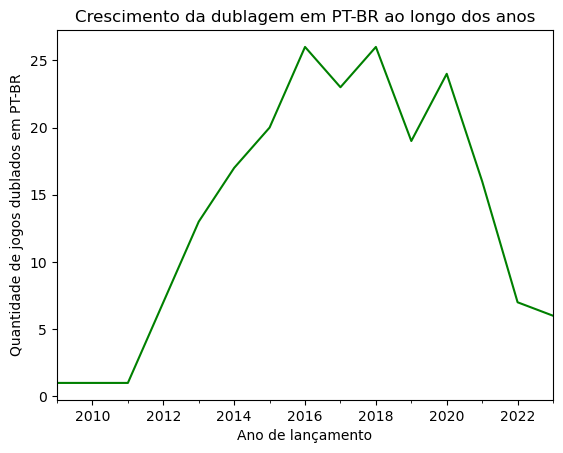

In [23]:
dublagem_pt_br_por_ano = dados_pt_br.groupby('Ano')['Dublagem_completa'].count()
ax = dublagem_pt_br_por_ano.plot.line(xlabel='Ano de lançamento', ylabel='Quantidade de jogos dublados em PT-BR', color='green')
plt.title('Crescimento da dublagem em PT-BR ao longo dos anos')
plt.show()


O *Gráfico 3.0* nos mostra que as empresas passaram a dublar jogos para o público brasileiro a partir de 2009, entretanto, foi apenas após o ano de 2012 que as coisas passaram a engatar de vez, talvez devido à popularidade atingida por *The Witcher 2*, como foi falado anteriormente, atingindo seu ápice nos anos de 2015 e 2018.

# 3.  Análise das relações entre variaveis

Agora iremos vê quais variáveis possuem relações entre si e seu grau de influência.


## 3.1 Visão geral dos dados

Aqui faremos investigaremos todos os dados juntos de modo que possamos perceber quais são as melhores correlações entre as variáveis para analisarmos.

### Gráfico 3.1

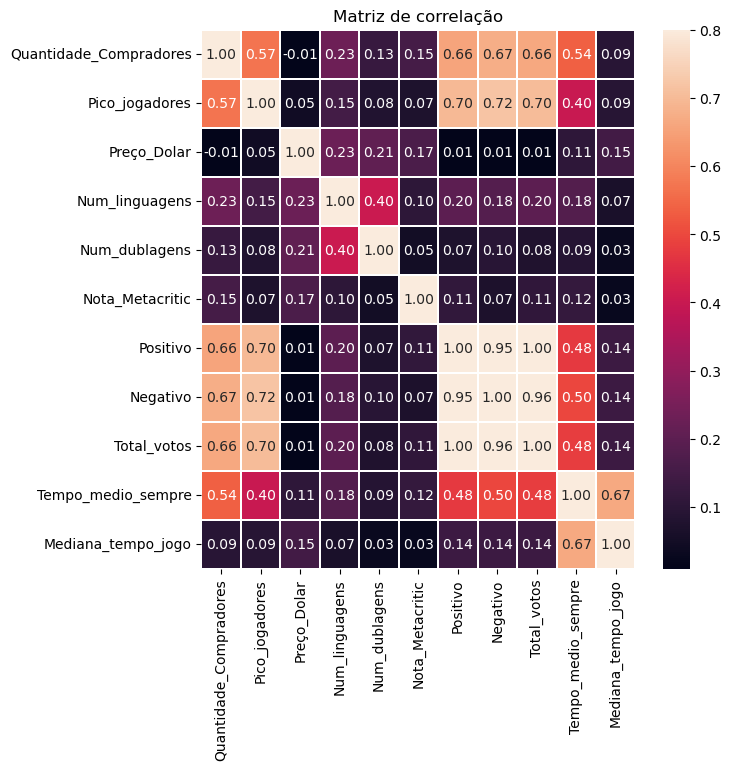

In [24]:
correlacao = dados.fillna(0).corr(numeric_only=True)

correlacao_formatada = correlacao.applymap(lambda x: '{:.2f}'.format(x))

plt.figure(figsize=(7, 7))
sns.heatmap(correlacao, annot=correlacao_formatada, fmt='', vmin=0.01, vmax=0.8, linewidths=0.1)
plt.title('Matriz de correlação')
plt.show()

O *Gráfico 3.1* nos mostra as potênciais melhores correlações, no entanto não é o bastante para concluirmos algo, então vamos averiguar mais a fundo as correlações mais promissoras e verificar se é possível concluir algo através destes dados.

## 3.2 Analisando se o pico de jogadores tem relação com o número de análises recebidas pelo jogo

Utilziremos o *Gráfico 3.2* para averiguar se há alguma correlação entre as variáveis.

### Gráfico 3.2

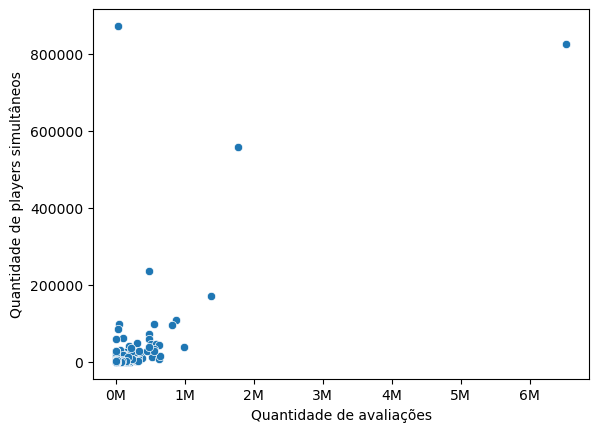

In [25]:
sns.scatterplot(x='Total_votos', y='Pico_jogadores', data=dados)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}M'.format(x / 1000000)))
plt.xlabel('Quantidade de avaliações')
plt.ylabel('Quantidade de players simultâneos')
plt.show()

É notório que conforme a quantidade de votos recebidos aumenta, o pico dos jogadores também tende a aumentar um pouco, exceto por alguns casos exepcionais. A seguir, usaremos uma análise com base nos métodos *Pearson, Spearman, Kendall* para um estudo mais preciso:

In [26]:
pd.Series({
    'pearson': dados.Pico_jogadores.corr(dados.Total_votos, method='pearson'),
    'spearman': dados.Pico_jogadores.corr(dados.Total_votos, method='spearman'),
    'kendall': dados.Pico_jogadores.corr(dados.Total_votos, method='kendall')
}, name='correlacao').to_frame()

,correlacao
pearson,0.703926
spearman,0.803895
kendall,0.617976


O resultado desses métodos podem ser interpretados do seguinte modo:

* Correlação Pearson (0,7) - sugere uma correlação positiva forte entre as variáveis, afinal os dados estão entre 0,7 e 1;

* Correlação Spearman (0,8) - indica uma correlação positiva forte entre as duas variáveis. Isso sugere que, em geral, quanto mais avaliações um jogo recebe, maior é o seu pico de jogadores, com menos influência de pontos discrepantes;

* Correlação Kendall (0,6) - sinaliza uma correlação positiva moderada entre as duas variáveis, mas pode ser um pouco mais conservador em relação à presença de empates nos dados.

Com isso podemos concluir que os dados possuem sim correlação, significando que conforme um valor aumenta o outro tanbém aumentará.

### 3.2.1 Investigando outliers

Como é possível notar pelo *Gráfico 3.2* há um outlier muito chamativo no pico de jogadores, este jogo em questão se difere muito dos demais que aparentam seguir o padrão linear, portanto, devemos fazer uma análise profunda e tentar descobrir o porquê.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


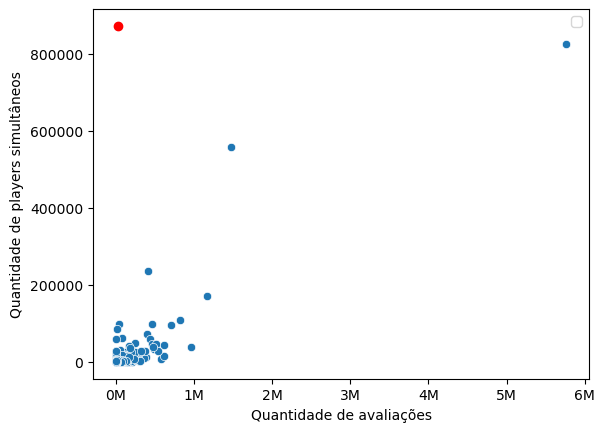

In [27]:

indice_max_pico = dados['Pico_jogadores'].idxmax()
sns.scatterplot(x='Positivo', y='Pico_jogadores', data=dados)
plt.scatter(dados.loc[indice_max_pico, 'Positivo'], dados.loc[indice_max_pico, 'Pico_jogadores'], color='red')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}M'.format(x / 1000000)))
plt.legend()
plt.xlabel('Quantidade de avaliações')
plt.ylabel('Quantidade de players simultâneos')
plt.show()

In [28]:
dados.sort_values(by='Pico_jogadores', ascending= False).head(1)

,Nome,Data_lançamento,Quantidade_Compradores,Pico_jogadores,Preço_Dolar,Linguas_suportadas,Num_linguagens,Dublagem_completa,Num_dublagens,Nota_Metacritic,Positivo,Negativo,Total_votos,Tempo_medio_sempre,Mediana_tempo_jogo,Desenvolvedores,Editores,Categorias,Generos,Mes,Ano
69429,Hogwarts Legacy,2023-02-10,7500000.0,872138,59.99,"['English', 'French', 'Italian', 'German', 'Sp...",14,"['English', 'French', 'Italian', 'German', 'Sp...",9,84,33521,2000,35521,661,501,Avalanche Software,Warner Bros. Games,"Single-player,Steam Achievements,Full controll...","Action,Adventure,RPG",2023-02,2023


O jogo em questão se trata de *Hogwarts Legacy*, um jogo de aventura e ação que se passa no universo da famosa saga *Harry Potter*. Estranhamente, apesar do jogo possuir um pico de jogadores tão alto, sua quantidade de avaliações recebidas foi deveras abaixo do esperado, afinal, não conseguiu sequer uma quantidade de avalições equivalente à metade do seu pico de jogadores. O motivo para isso Talvez tenha sido devido a campanha de cancelamento do game que houve nas redes sociais devido a algumas declarações de J.K. Rowling, autora de *Harry Potter*, que acabou por afetar negativamente o interesse dos fãs pela saga.

Fonte: https://www1.folha.uol.com.br/ilustrada/2023/02/fas-de-hogwarts-legacy-sao-acusados-de-financiar-transfobia-de-jk-rowling.shtml

## 3.3 Averiguando se o tempo médio de jogatina tem alguma relação com o pico de jogagores dos jogos

Utilziremos o *Gráfico 3.3* para investigar se há alguma correlação entre as variáveis.

### Gráfico 3.3

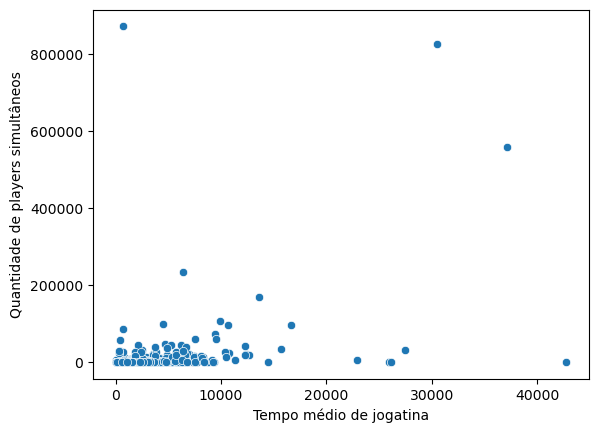

In [29]:
sns.scatterplot(x='Tempo_medio_sempre', y='Pico_jogadores', data=dados)
plt.xlabel('Tempo médio de jogatina')
plt.ylabel('Quantidade de players simultâneos')
plt.show()

É pouco perceptível se há, de fato, alguma correlação entre as variáveis obervando o *Gráfico 3.3*, portanto, iremos utilizar-nos dos métodos *Pearson, Spearman, Kendall* para uma maior precisão na análise.

In [30]:
pd.Series({
    'pearson': dados.Pico_jogadores.corr(dados.Tempo_medio_sempre, method='pearson'),
    'spearman': dados.Pico_jogadores.corr(dados.Tempo_medio_sempre, method='spearman'),
    'kendall': dados.Pico_jogadores.corr(dados.Tempo_medio_sempre, method='kendall')
}, name='correlacao').to_frame()

,correlacao
pearson,0.398855
spearman,0.665499
kendall,0.488748


O resultado desses métodos podem ser interpretados do seguinte modo:

* Correlação Pearson (0,39) - sugere uma correlação positiva moderada entre as variáveis, afinal, os dados estão entre 0,3 e 0,5;

* Correlação Spearman (0,66) - indica uma correlação positiva forte, pois seu resultado está entre 0,6 e 1. Isso sugere que quanto maior o pico de jogadores de um jogo, maior será seu tempo médio de jogatina entre os players;

* Correlação Kendall (0,48) - sinaliza  uma correlação positiva moderada, pois seu resultado está entre 0,4 e 0,7.

Em resumo, todos esses coeficientes indicam que há alguma forma de relação entre as variáveis, sendo mais forte a correlação segundo o método de Spearman.

### 3.3.1 Investigando outliers

Algo que chama muita atenção no *Gráfico 3.3* são seus outliers, ou seja, os jogos que não seguem o padrão dos demais, aqui está o *Gráfico 3.4* que destaca estes jogos.


#### Gráfico 3.4

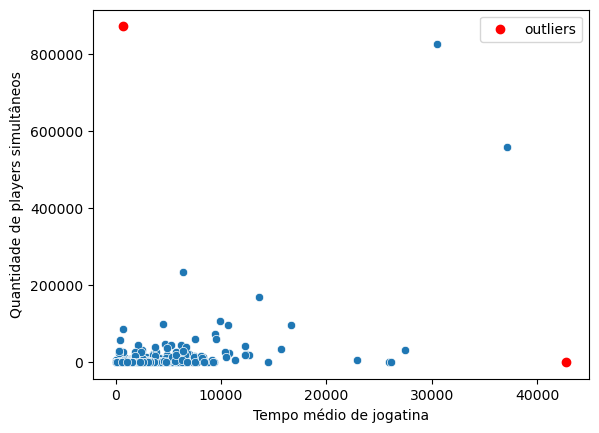

In [31]:
indice_max_tempo = dados['Tempo_medio_sempre'].idxmax()
indice_max_pico = dados['Pico_jogadores'].idxmax()
sns.scatterplot(x='Tempo_medio_sempre', y='Pico_jogadores', data=dados)
plt.scatter(dados.loc[indice_max_tempo, 'Tempo_medio_sempre'], dados.loc[indice_max_tempo, 'Pico_jogadores'], color='red', label='outliers')
plt.scatter(dados.loc[indice_max_pico, 'Tempo_medio_sempre'], dados.loc[indice_max_pico, 'Pico_jogadores'], color='red')
plt.legend()
plt.xlabel('Tempo médio de jogatina')
plt.ylabel('Quantidade de players simultâneos')
plt.show()

#### 3.3.1.1 Examinando por que o jogo com maior pico de jogadores tem um tempo médio de jogatina tão baixo

O jogo com maior pico de jogadores ter um tempo médio de jogatina extremamente abaixo da média é um fato deveras curioso, isso faz com que seja interessante investigarmos mais a fundo o motivo deste fenômeno, mas primeiro devemos decobrir de qual jogo estamos falando.

In [32]:
dados.sort_values(by='Pico_jogadores', ascending= False ).head(1)

,Nome,Data_lançamento,Quantidade_Compradores,Pico_jogadores,Preço_Dolar,Linguas_suportadas,Num_linguagens,Dublagem_completa,Num_dublagens,Nota_Metacritic,Positivo,Negativo,Total_votos,Tempo_medio_sempre,Mediana_tempo_jogo,Desenvolvedores,Editores,Categorias,Generos,Mes,Ano
69429,Hogwarts Legacy,2023-02-10,7500000.0,872138,59.99,"['English', 'French', 'Italian', 'German', 'Sp...",14,"['English', 'French', 'Italian', 'German', 'Sp...",9,84,33521,2000,35521,661,501,Avalanche Software,Warner Bros. Games,"Single-player,Steam Achievements,Full controll...","Action,Adventure,RPG",2023-02,2023


O jogo em questão se trata de *Hogwarts Legacy*, um jogo de aventura e ação que se passa no universo da famosa saga *Harry Potter*. Não se sabe ao certo os motivos para este jogo ter tão pouco tempo de jogatina, é fato que milhões de fãs de *Harry Potter* compraram o game e se aventuraram nesse mundo mágico, mas ao que parece, logo os fãs perderam o entusiasmo e cerca de apenas 25% dos jogadores cehgaram a terminar o jogo.

Fonte: https://www.adrenaline.com.br/games/hogwarts-legacy-perdeu-95-dos-jogadores-no-pc-em-40-dias/

#### 3.3.1.2 Averiguando por que o jogo com maior tempo de jogatina tem um pico de jogares tão baixo

O jogo com maior tempo médio de jogatina ter um pico de jogadores abaixo da média é instigante, afinal, como um jogo pode ter tanto tempo de jogatina sem ter tido um alto pico de jogadores em algum momento, isso faz com que seja preciso analisarmos mais a fundo o motivo deste fenômeno, mas primeiro devemos decobrir de qual jogo estamos falando.

In [33]:
dados.sort_values(by='Tempo_medio_sempre', ascending= False ).head(1)

,Nome,Data_lançamento,Quantidade_Compradores,Pico_jogadores,Preço_Dolar,Linguas_suportadas,Num_linguagens,Dublagem_completa,Num_dublagens,Nota_Metacritic,Positivo,Negativo,Total_votos,Tempo_medio_sempre,Mediana_tempo_jogo,Desenvolvedores,Editores,Categorias,Generos,Mes,Ano
47532,Brigade E5: New Jagged Union,2014-04-30,10000.0,2,3.99,"['English', 'Russian', 'German']",3,[],0,41,73,34,107,42773,42773,Apeiron,Fulqrum Publishing,"Single-player,Steam Cloud","Simulation,Strategy",2014-04,2014


Trata-se do jogo *Brigade E5: New Jagged Union*, um jogo tático que coloca os jogadores na pequena nação tropical de Palinero à beira de uma guerra civil. Apesar de ser um jogo nichado, a base de fãs que o jogo conquistou é bastante fiel ao mesmo, provavelmente deve-se ao fato das mecânicas únicas no jogo, como por exemplo o recurso SPM, um novo recurso para os jogos de estratégias que garante que todos os jogadores terão a chance de comandar seus soldados ao mesmo tempo.

Fonte: https://hype.games/br/brigade-e5-new-jagged-union

## 3.4 Analisando se a quantidade de avaliações positivas influênciam na quantidade de avaliações Negativas

Agora iremos verificar se a quantidade de votos positivos tem alguma relação com a quantidade de votos negativos, queremos descobrir se a medida que uma variável aumenta a outra tende a diminiuir ou aumentar junto com a outra variável. Para isto, usaremos o *Gráfico 3.5* para uma análise visual

### Gráfico 3.5

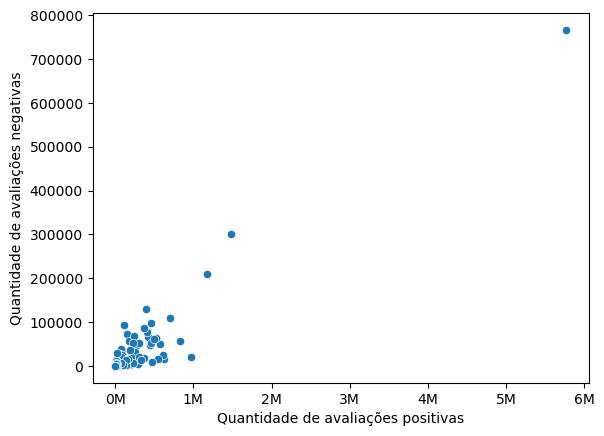

In [34]:
sns.scatterplot(x='Positivo', y='Negativo', data=dados)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}M'.format(x / 1000000)))
plt.xlabel('Quantidade de avaliações positivas')
plt.ylabel('Quantidade de avaliações negativas')
plt.show()

Como é possível notar, a uma destribuição linear dos dados, dando a entender que, realmente, quando uma variável tende a aumentar, a outra também aumentará, nem que seja apenas um pouco. Para uma conclusão mais precisas usaremos os métodos *Pearson, Spearman, Kendall* para uma nova análise.

In [35]:
pd.Series({
    'pearson': dados.Negativo.corr(dados.Positivo, method='pearson'),
    'spearman': dados.Negativo.corr(dados.Positivo, method='spearman'),
    'kendall': dados.Negativo.corr(dados.Positivo, method='kendall')
}, name='correlacao').to_frame()

,correlacao
pearson,0.947610
spearman,0.840739
kendall,0.650706


O resultado desses métodos podem ser interpretados do seguinte modo:

* Correlação Pearson (0,94) - indica uma forte correlação positiva linear entre as variáveis. Isso sugere que, à medida que uma variável aumenta, a outra variável também tende a aumentar de forma linear;

* Correlação Spearman (0,84) - sugere uma forte associação monótona positiva entre as variáveis. Isso sugere que quanto maior a quantidade de avaliações positivas de um jogo, maior será sua quantidade de avaliações negativas;

* Correlação Kendall (0,65) - demonstra haver uma forte concordância entre as ordens das variáveis.

Em resumo, todos os três coeficientes de correlação indicam uma forte associação positiva entre as variáveis analisadas, sugerindo que as variáveis tendem a aumentar ou diminuir juntas.

### 3.4.1 Investigando mais a fundo as duas variáveis

Por mais que as análises anteriores nos deram conclusões bem sólidas, é preciso uma investigação mais a fundo à respeito das variáveis, por exemplo, iremos analisar a porcentagem que as avaliações positivas e negativas representam no total de avaliações recebidas por um jogo.

In [36]:
df_original = pd.DataFrame(dados)

df = df_original.loc[:, ['Nome','Nota_Metacritic','Total_votos', 'Positivo', 'Negativo','Quantidade_Compradores']]
df['Porcentagem_Positiva'] = round((df['Positivo'] / df['Total_votos']) * 100)
df['Porcentagem_Negativa'] = round((df['Negativo'] / df['Total_votos']) * 100)

#### 3.4.1.1 O jogo com mais avaliações positivas também é o jogo com a maior porcentagem de avaliações positivas?

In [37]:
df.sort_values(by='Positivo', ascending=False).head(1)

,Nome,Nota_Metacritic,Total_votos,Positivo,Negativo,Quantidade_Compradores,Porcentagem_Positiva,Porcentagem_Negativa
46158,Counter-Strike: Global Offensive,83,6531097,5764420,766677,75000000.0,88.0,12.0


In [38]:
df.sort_values(by='Porcentagem_Positiva', ascending=False).head(1)

,Nome,Nota_Metacritic,Total_votos,Positivo,Negativo,Quantidade_Compradores,Porcentagem_Positiva,Porcentagem_Negativa
39058,The Procession to Calvary,78,606,597,9,35000.0,99.0,1.0


Estranhamente o jogo com o melhor porcentagem de avaliações positivas é *The Procession to Calvary*, um jogo totalmente nichado e desconhecido pela maioria das pessoas, enquanto o famoso *Counter-Strike: Global Offensive*, apesar de possuir mais avaliações positivas, está abaixo no ranking porcentagem de avaliações positivas.

#### 3.4.1.2 O jogo com mais avaliações negativas também é o jogo com a maior porcentagem de avaliações negativas?

In [39]:
df.sort_values(by='Negativo', ascending=False).head(1)

,Nome,Nota_Metacritic,Total_votos,Positivo,Negativo,Quantidade_Compradores,Porcentagem_Positiva,Porcentagem_Negativa
46158,Counter-Strike: Global Offensive,83,6531097,5764420,766677,75000000.0,88.0,12.0


In [40]:
df.sort_values(by='Porcentagem_Negativa', ascending=False).head(1)

,Nome,Nota_Metacritic,Total_votos,Positivo,Negativo,Quantidade_Compradores,Porcentagem_Positiva,Porcentagem_Negativa
5410,Flatout 3: Chaos & Destruction,23,3153,506,2647,150000.0,16.0,84.0


Aqui temos *Counter-Strike: Global Offensive* novamente, demonstrando também ser o jogo com maior quantidade de avaliações negativas, algo que nos leva para nossa análise anterior, afinal, conforme uma variável aumenta, a outra tende a aumentar junto. Já o jogo com maior porcentagem de avaliações negativa se trata de *Flatout 3: Chaos & Destruction*, jogo este que foi massacrado pelos fãs da franquia durante sua lançamento, afinal, o game possuí gráficos abaixos do esperado e péssima jogabilidade, o que levou o game a receber uma onda de avaliações negativas.

Fonte: https://www.gamevicio.com/noticias/2011/12/flatout-3-chaos-e-destruction-jogo-e-massacrado-na-web/

### 3.4.2 Analisando se há alguma relação entre as variáveis

Dentre as novas váriaveis criadas, iremos analisar se elas possuem alguma relação com outra variável já existente.

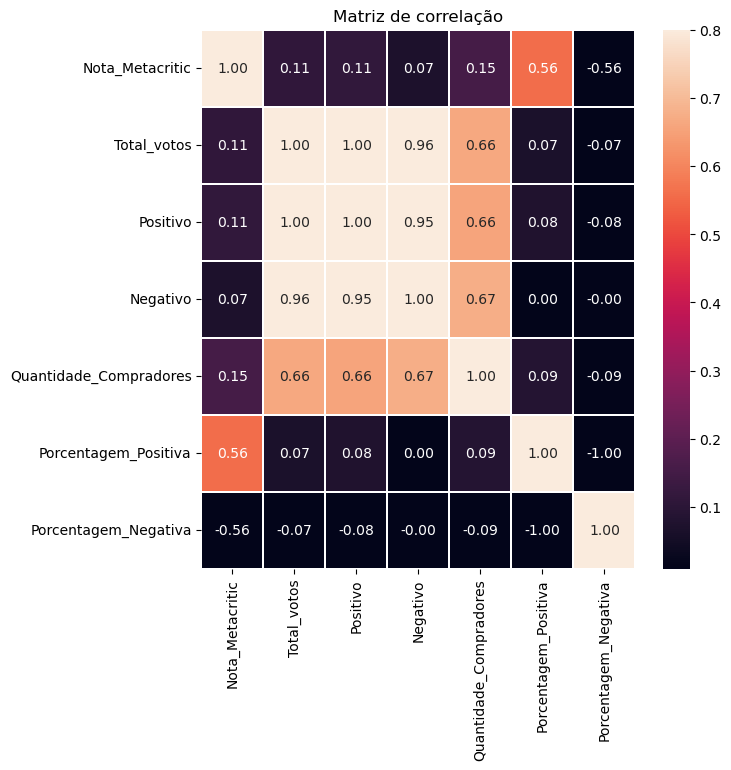

In [41]:
correlacao = df.fillna(0).corr(numeric_only=True)
correlacao_formatada = correlacao.applymap(lambda x: '{:.2f}'.format(x))

plt.figure(figsize=(7,7))
sns.heatmap(correlacao, annot=correlacao_formatada, fmt='', vmin=0.01, vmax=0.8, linewidths=0.1)
plt.title('Matriz de correlação')
plt.show()

#### 3.4.2.1 Verificando se a nota metacritic tem relação com a porcentagem de avaliações positivas

Como é possivel notar no *Gráifico 3.6* apenas essa relação entre variáveis se demonstrou ser interessante para analisarmos, a seguir veremos o *Gráfico 3.7* para uma análise visual dos dados.

#### Gráfico 3.7

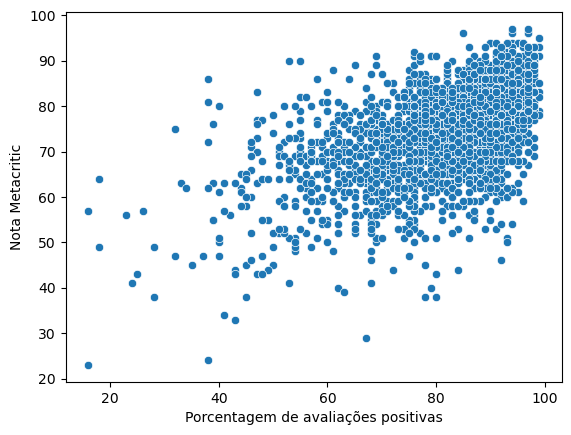

In [42]:
sns.scatterplot(x='Porcentagem_Positiva', y='Nota_Metacritic', data=df)
plt.xlabel('Porcentagem de avaliações positivas')
plt.ylabel('Nota Metacritic')
plt.show()

É notório que os dados estão muito espalhados na gráfico, entretanto, eles ainda aparentam seguir um padrão linear. Para que seja possível concluirmos algo usaremos os métodos *Pearson, Spearman, Kendall* para uma nova análise de correlação.

In [43]:
pd.Series({
    'pearson': df.Nota_Metacritic.corr(df.Porcentagem_Positiva, method='pearson'),
    'spearman': df.Nota_Metacritic.corr(df.Porcentagem_Positiva, method='spearman'),
    'kendall': df.Nota_Metacritic.corr(df.Porcentagem_Positiva, method='kendall')
}, name='correlacao').to_frame()

,correlacao
pearson,0.557316
spearman,0.543244
kendall,0.394675


O resultado desses métodos podem ser interpretados do seguinte modo:

* Correlação Pearson (0,55) - sugere uma correlação moderada entre as variáveis. indicando que elas tendem a aumentar ou diminuir juntas, mas não necessariamente em uma relação linear perfeita

* Correlação Spearman (0,54) - indica uma relação positiva moderada monotônica entre as variáveis, mas não necessariamente linear.

* Correlação Kendall (0,39) - demonstra haver uma concordância moderada entre as variáveis.

Em resumo, todos os três coeficientes de correlação indicam correlação moderada positiva entre as variáveis analisadas, sugerindo que as variáveis tendem a aumentar ou diminuir juntas, mas não de maneira linearmente perfeita.

# 4. Análise de Regração Linear/Multipla

## 4.1 Regressão Linear entre a porcentagem de avaliações positivas e a nota do jogo no Metacritic

Aqui utilizaremos a *Regressão Linear* para tentar inferir se é possível predizer a porcentagem de avaliações positivas de um jogo com base nas sua nota do site Metacritic

In [44]:
dados['Positivo'] = round((dados['Positivo'] / dados['Total_votos']) * 100)
dados['Negativo'] = round((dados['Negativo'] / dados['Total_votos']) * 100)
dados.rename(columns={'Positivo': 'Porcentagem_Positiva', 'Negativo': 'Porcentagem_Negativa'}, inplace=True)

In [45]:
from sklearn.linear_model import LinearRegression

X = dados[['Nota_Metacritic']]  # Variável independente
Y = dados['Porcentagem_Positiva']  # Variável dependente
modelo = LinearRegression()
modelo.fit(X, Y)

print(f'Intercepto: {modelo.intercept_: .2f}')
print(f'Coeficiente: {modelo.coef_[0]: .2f}')

Intercepto:  26.46
Coeficiente:  0.74


O resultado sugere que a porcentagem positiva de avaliações é influênciada pela nota do site Metacritic, sendo relevante as seguinter informações:

* O intercepto representa o valor da variável dependente (Porcentagem_Positiva) quando a variável independente (Nota_Metacritic) é igual a zero, ou seja, quando a Nota_Metacritic for igual a zero, o valor da variável Porcentagem_Positiva será, aproximadamente, igual a 26,46;

* O coeficiente representa a mudança esperada na variável dependente (Porcentagem_Positiva) para uma unidade de mudança na variável independente (Nota_Metacritic), mantendo todas as outras variáveis constantes, significa dizer que quando Nota_Metacritic subir ou diminuir sua nota em uma unidade, o valor da variável Porcentagem_Positiva será alterada em +0,74 ou -0,74, dependendo se o valor de Nota_Metacritic aumentou ou diminuiu.

Resumidamente, o modelo sugere que há uma relação entre a nota do Metacritic e a porcentagem de avaliações positivas, onde um aumento na nota do Metacritic está associado a um aumento na porcentagem de avaliações positivas, e vice-versa.

### Gráfico 4.1

c:\Users\bruns\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


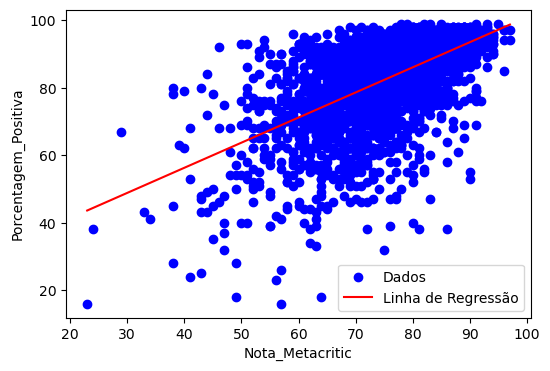

In [46]:
X_min = dados['Nota_Metacritic'].min()
X_max = dados['Nota_Metacritic'].max()
X_range = np.linspace(X_min, X_max, 100).reshape(-1, 1)
Y_pred = modelo.predict(X_range)

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X, Y, color='blue', label='Dados')
ax.plot(X_range, Y_pred, color='red', label='Linha de Regressão')
ax.set_xlabel('Nota_Metacritic')
ax.set_ylabel('Porcentagem_Positiva')
ax.legend()
plt.show()
warnings.filterwarnings('ignore', message="X does not have valid feature names.*")

Como podemos vê no *Gráfico 4.1*, os dados seguem um padrão linear, por mais que estejam dispersos, ainda aparentam seguir a reta do modelo.

### 4.1.1 Avaliando o modelo 

Usaremos o scikit-learn para averiguar quão preciso e nosso modelo de Regressão Linear.

In [47]:
from sklearn.metrics import mean_squared_error, r2_score
fitted = modelo.predict(X)

RMSE = np.sqrt(mean_squared_error(Y, fitted))
r2 = r2_score(Y, fitted)

print(f'Root Mean Square Error (RMSE): {RMSE:.0f}')
print(f'Coefficient of determination (r²): {r2:.4f}')

Root Mean Square Error (RMSE): 11
Coefficient of determination (r²): 0.3106


Com esses resultados podemos concluir que:

* RMSE (11) - representa o desvio médio entre os valores previstos pelo modelo e os valores reais. Quanto menor o valor do RMSE, melhor o modelo se ajusta aos dados, como nosso valor de RMSE é de 11, significa dizer que nosso modelo de ajusta muito bem aos dados;

* r2 -  constitui a proporção da variabilidade dos dados da variável dependente que é explicada pelas variáveis independentes incluídas no modelo. No caso de r2 ser 0,3105, significa que cerca de 31.05% da variabilidade na Porcentagem_Positiva é explicada pela Nota_Metacritic no nosso modelo de regressão linear.

Em resumo, nosso modelo se ajusta muito bem aos dados e explica uma proporção significativa da variabilidade dos dados, entretanto, ainda há uma quantidade substancial de variabilidade que não é explicada pelo modelo.

### 4.1.2 Analisando previsões

In [48]:
df = dados

X = df[['Porcentagem_Positiva', 'Nota_Metacritic']]
y = df['Total_votos']

model = LinearRegression()

model.fit(X, y)

coefficients = model.coef_
intercept = model.intercept_

print("Coeficientes:")
for i, coef in enumerate(coefficients):
    print(f"X{i+1}: {coef}")
print(f"Intercept: {intercept}")


predictions = model.predict(X)
r2 = r2_score(y, predictions)
print(f'R²: {r2:.2f}')

Coeficientes:
X1: 103.95929598625807
X2: 1568.8302544273065
Intercept: -105743.70499489948
R²: 0.01


O R² de 0.01 indica que apenas 1% da variabilidade na variável dependente (Total_votos) pode ser explicada pelas variáveis independentes incluídas no modelo, mesmo após a normalização dos dados. Isso sugere que o modelo não está capturando adequadamente os padrões nos dados.

#### Gráfico 4.2

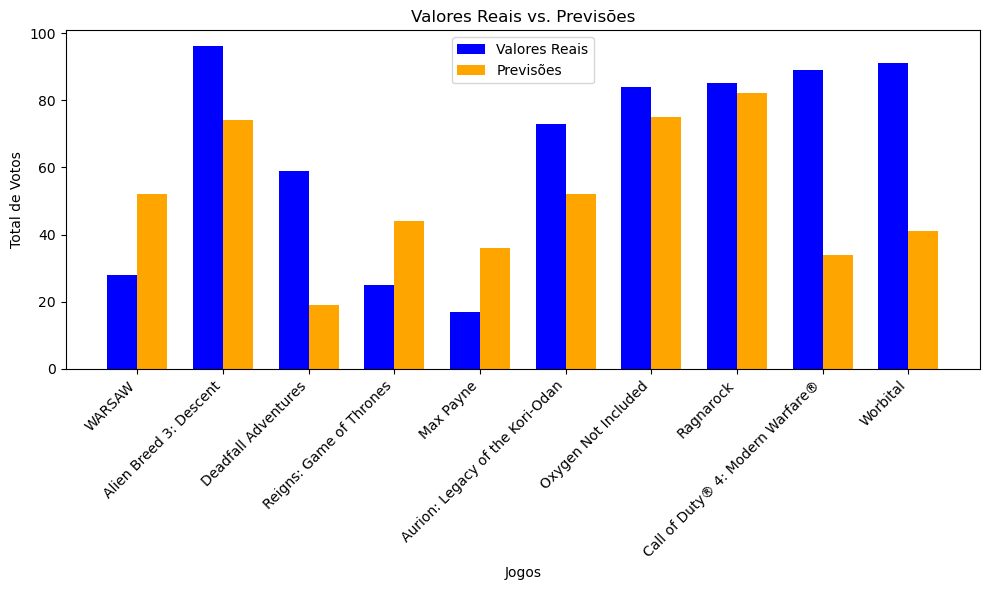

In [49]:
plt.figure(figsize=(10, 6))  

nomes_jogos = dados['Nome'][:10].values

y = np.random.randint(10, 100, size=10)  
predictions = np.random.randint(10, 100, size=10)  

bar_width = 0.35

plt.bar(np.arange(10), y, bar_width, color='blue', label='Valores Reais')
plt.bar(np.arange(10) + bar_width, predictions, bar_width, color='orange', label='Previsões')

plt.xlabel('Jogos')
plt.ylabel('Total de Votos')
plt.title('Valores Reais vs. Previsões')
plt.legend()

plt.xticks(np.arange(10) + bar_width / 2, nomes_jogos, rotation=45, ha='right')

plt.tight_layout()
plt.show()

Como é possível observar, os valores reais e as previsões estão relativamente próximos um do outro, exceto por algumas excessões, isso demonstra que o modelo geralmente acerta em suas previsões, ou pelo menos chega próximo ao valor real, entretanto, há casos excepcionais que o modelo não consegue prevê.

## 4.2 Regressão Múltipla pra tentar predizer quantos compradores terá um jogo
Aqui iremos tentar predizer a quantidade de compradores de um jogo com base nas variáveis *Total_voto*, *Pixo_jogadores* e *Tempo_medio_sempre*.

### 4.2.1 Regressão Multipla
Aqui faremos uma regressão multipla utilizando as variáveis independentes *Total_votos*, *Pico_jogadores* e *Tempo_medio_sempre* para tentar chegar ao valor da variável dependente *Quantidade_Compradores*

In [50]:
predictors = ['Total_votos', 'Pico_jogadores', 'Tempo_medio_sempre']
outcome = 'Quantidade_Compradores'

dados_lm = LinearRegression()
dados_lm.fit(dados[predictors], dados[outcome])

print(f'Intercept: {dados_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, dados_lm.coef_):
    print(f' {name}: {coef}')

Intercept: 332781.233
Coefficients:
 Total_votos: 13.444233265617989
 Pico_jogadores: 31.815440542633368
 Tempo_medio_sempre: 612.2375476289915


Utilizando o método de Regressão Múltipla chegamos aos seguintes resultados iniciais:

Intercept - O intercepto é o valor esperado da variável dependente (quantidade de compradores, neste caso) quando todas as variáveis independentes (Total_votos, Pico_jogadores e Tempo_medio_sempre) são iguais a zero. Com nosso resultado de 332781.233, significa dizer que, se todas as variáveis independentes forem zero, espera-se que a quantidade de compradores seja de aproximadamente 332781.233.

Coefficients - Os coeficientes indicam a relação entre cada variável independente (predictor) e a variável dependente (quantidade de compradores), a seguir temos a análise por variavel independente: 

* Total_votos - O coeficiente para Total_votos é 13.444233265617989, significando que, mantendo os outros preditores constantes, um aumento unitário em Total_votos está associado a um aumento de aproximadamente 13,44 na quantidade de compradores. Portanto, quanto mais votos tiver, espera-se que o número de compradores aumente em cerca de 13,44 para cada voto adicional;

* Pico_jogadores - O coeficiente para Pico_jogadores é 31.815440542633368, significando que um aumento no pico de jogadores está relacionado a um aumento de cerca de 31,82 na quantidade de compradores, mantendo os outros fatores constantes;

* Tempo_medio_sempre - O coeficiente para Tempo_medio_sempre é 612.2375476289915. Portanto, um aumento no tempo médio de jogatina está relacionado a um aumento substancial de cerca de 612,24 na quantidade de compradores, mantendo os outros fatores constantes.

Resumidamente, esses resultados indicam que cada variável independente contribui para prever a quantidade de compradores. Além disso, o coeficiente positivo indica que um aumento na variável independente está associado a um aumento na quantidade de compradores.

### 4.2.2 Avaliando o modelo
Utilizaremos os Métodos RMSE E R2 para avaliar a precição de nosso modelo.

In [51]:
fitted = dados_lm.predict(dados[predictors])
RMSE = np.sqrt(mean_squared_error(dados[outcome], fitted))
r2 = r2_score(dados[outcome], fitted)
print(f'Root Mean Square Error (RMSE): {RMSE:.0f}')
print(f'Coefficiente of determination (r²): {r2:.4f}')

Root Mean Square Error (RMSE): 3307576
Coefficiente of determination (r²): 0.5157


Com base nos resultados obtidos temos as seguintes conclusões podem ser feitas:

* RMSE - O alto valor de RMSE sugere que as previsões do modelo têm uma precisão relativamente baixa em relação aos valores reais, indicando que o modelo não está capturando completamente os padrões nos dados;

* R²: O valor de R² de 0.5157 indica que o modelo explica aproximadamente 51,57% da variabilidade nos dados, sugerindo que o modelo tem alguma utilidade em prever a quantidade de compradores.

Em resumo, o modelo tem um desempenho razoável em explicar parte da variabilidade *Quantidade_Compradores*, mas há espaço para melhorias na precisão das previsões.

### Gráfico 4.3

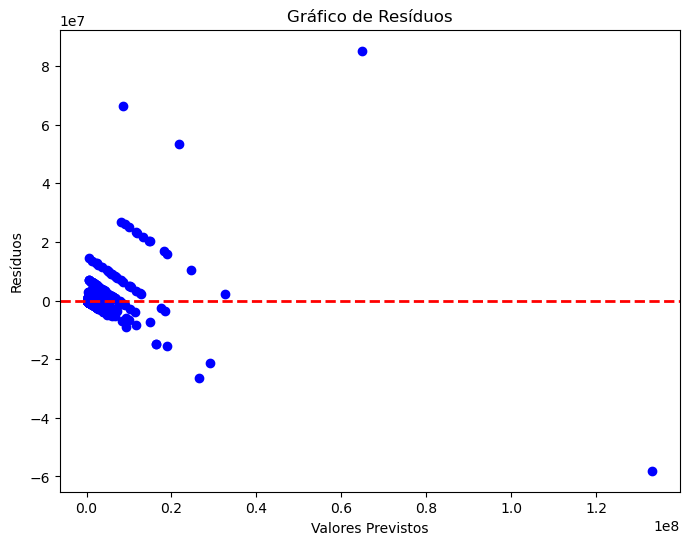

In [52]:
plt.figure(figsize=(8, 6))
plt.scatter(fitted, dados[outcome] - fitted, color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Gráfico de Resíduos')
plt.show()

O *Gráfico 4.3* tratase de um gráfico de resíduos, nele podemos ter uma vizualização da diferença entre os resíduos (diferença entre os valores previstos pelo modelo em relação aos valores observados) em relação aos valores observados. A partir dele podemos chegar às seguintes conclusões:

* Padrões - O gráfico aparenta possuir um padrão na destribuição dos dados e isso acaba por ser um problema para o modelo, podende significar a presença de heterocedasticidade, onde a variância dos erros não é constante em todas as faixas dos valores previstos, podendo levar a estimativas de parâmetros enviesadas e intervalos de confiança imprecisos.

* Pontos acima e abaixo da linha de resíduos - Significa que o modelo está subestimando e , ao mesmo tempo, superestimando alguns valores, o que pode vir a ser um problema para o modelo. 

* Outliers - outliers nos resíduos podem indicar observações incomuns ou erros no modelo.

Em resumo, nosso modelo atual é bastante impreciso em suas análises, possuindo um viés que o faz subestimar e superestimar os valores dos dados a serem previstos.

### 4.2.3 Implementando novos metódos para manipulação dos dados afim de melhorar o modelo
Agora iremos aplicar métodos como remorsão de outliers do modelo, divisão dos dados e treinamento do modelo, ao final de tudo verificaremos se tivemos um desempenho melhor utilizando dessas estratégias.

In [53]:
outliers = dados[((dados['Total_votos'] - dados['Total_votos'].mean()) / dados['Total_votos'].std()).abs() > 2]
dados_sem_outliers = dados.drop(outliers.index)

scaler = StandardScaler()
predictors = ['Total_votos', 'Pico_jogadores', 'Tempo_medio_sempre']
outcome = 'Quantidade_Compradores'
dados_sem_outliers[predictors] = scaler.fit_transform(dados_sem_outliers[predictors])

X_train, X_test, y_train, y_test = train_test_split(dados_sem_outliers[predictors], dados_sem_outliers[outcome], test_size=0.5, random_state=42)

dados_lm = LinearRegression()
dados_lm.fit(X_train, y_train)

predito_teste = dados_lm.predict(X_test)

RMSE_teste = np.sqrt(mean_squared_error(y_test, predito_teste))
r2_teste = r2_score(y_test, predito_teste)
print("Resultado do teste do modelo:")
print(f'Root Mean Square Error (RMSE) dos dados de testes: {RMSE_teste:,.2f}')
print(f'Coefficient of determination (R²) dos dados de testes: {r2_teste:.4f}')

jogos_exist = dados_sem_outliers.sample(n=10, random_state=4)
predito = dados_lm.predict(jogos_exist[predictors])
jogos_exist['Quantidade_Compradores_Predito'] = predito
print("\nResultado da previsão de jogos aleatórios:\n")
print(jogos_exist[[outcome, 'Quantidade_Compradores_Predito']].applymap(lambda x: "{:,.0f}".format(x)))

fitted = dados_lm.predict(dados_sem_outliers[predictors])
RMSE = np.sqrt(mean_squared_error(dados_sem_outliers[outcome], fitted))
r2 = r2_score(dados_sem_outliers[outcome], fitted)
print(f'\nRoot Mean Square Error (RMSE) (sem outliers): {RMSE:,.2f}')
print(f'Coefficient of determination (R²) (sem outliers): {r2:.4f}')

accuracy = 1 - (np.mean(np.abs(predito - jogos_exist[outcome])) / np.mean(jogos_exist[outcome]))
print(f'\nAcurácia do modelo: {accuracy:.2%}')

Resultado do teste do modelo:
Root Mean Square Error (RMSE) dos dados de testes: 2,138,743.05
Coefficient of determination (R²) dos dados de testes: 0.3754

Resultado da previsão de jogos aleatórios:

      Quantidade_Compradores Quantidade_Compradores_Predito
6898                 750,000                        430,139
1761               3,500,000                      4,502,843
57594                750,000                        929,626
19380                750,000                        861,834
22326                350,000                        628,488
58956                150,000                        336,461
48033              3,500,000                      2,046,926
8248                 150,000                        345,950
46635                350,000                        332,620
38325                150,000                        413,551

Root Mean Square Error (RMSE) (sem outliers): 1,708,088.49
Coefficient of determination (R²) (sem outliers): 0.4304

Acurácia do modelo: 6

Resumidamente este resultado significa: 

* RMSE dos dados de teste (2,138,743.05) - este valor representa a raiz do erro quadrático médio entre as previsões do modelo e os valores reais nos dados de teste,  o valor relativamente alto indica que o modelo tem um erro considerável nas previsões;

* R² dos dados de teste (0.3754) - é o coeficiente de determinação, que varia de 0 a 1 e indica a proporção da variância na variável dependente que é previsível a partir dos preditores. Nesse caso, O valor de 0.3754 indica que o modelo explica cerca de 37,54% da variância nos dados de teste, o que não é muito alto;

* RMSE (sem outliers) (1,708,088.49) - Comparado com o RMSE dos dados de teste, este é um pouco menor, o que sugere que o modelo ajusta-se um pouco melhor aos dados quando os outliers são removidos.

* R² (sem outliers) (0.4304) - Comparado com o R² dos dados de teste, este valor é um pouco maior, indicando que o modelo explica cerca de 43,04% da variância nos dados sem outliers.

* Acurácia (61.45%) - Mede quão próximas as previsões do modelo estão dos valores reais para os jogos existentes. O valor de 61.45% indica que, em média, as previsões estão corretas em cerca de 61.45% da quantidade real de compradores, sugerindo haver uma precisão relativamente moderada no modelo.

Em resumo, o modelo de regressão tem um desempenho moderado na previsão da quantidade de compradores de jogos, explicando apenas uma parte da variação nos dados e com um erro considerável nas previsões

### Gráfico 4.4

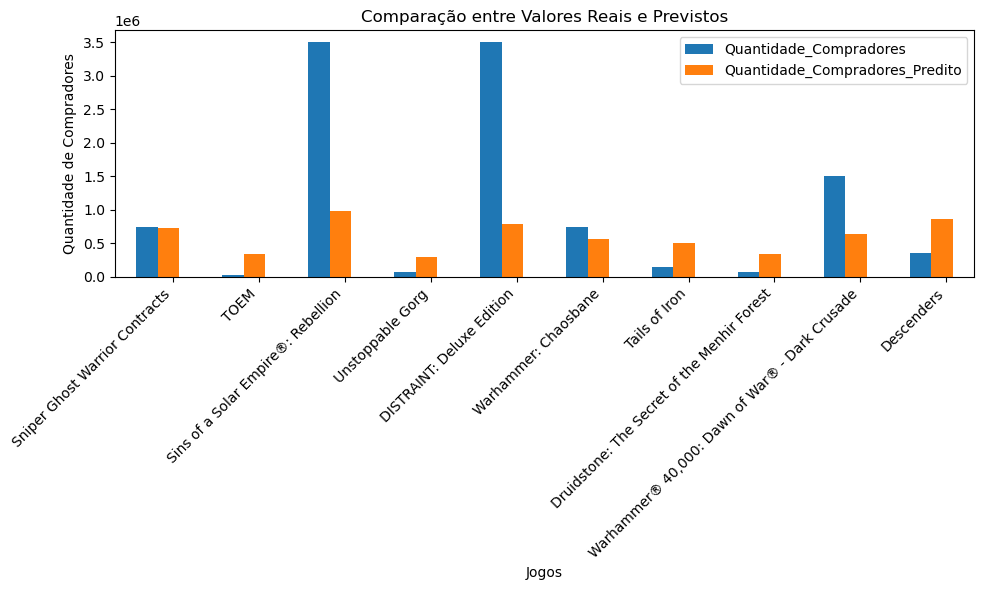

In [54]:
jogos_exist = dados_sem_outliers.sample(n=10, random_state=6)
predito = dados_lm.predict(jogos_exist[predictors])

df_comparison = jogos_exist[[outcome]].copy()
df_comparison['Quantidade_Compradores_Predito'] = predito

plt.figure(figsize=(10, 6))
df_comparison.plot(kind='bar', ax=plt.gca())
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Jogos')
plt.ylabel('Quantidade de Compradores')

nomes_jogos = jogos_exist['Nome']
index = np.arange(len(nomes_jogos))  
bar_width = 0.35  
plt.xticks(index + bar_width / 2, nomes_jogos, rotation=45, ha='right')

plt.tight_layout()
plt.show()


O *Gráfico 4.4* mostra quão alta é a precisão do modelo em alguns casos específicos, em contraste com quão baixa ela é em outros casos, principalmente casos que envolvam jogos com uma alta média de compradores, mostrando que o modelo tende a subestimar a quantidade de compradores de alguns jogos.

## 4.3 Avaliando se é possível melhorar a Regressão Múltipla utilizando os gêneros dos jogos como variáveis

Aqui faremos análises sobre tópicos que podem vir a nos dar resultados interessantes, como analisar jogos por gênero, quantidade de dublagens e línguas suportadas.

### 4.3.1 Preparado os dados

Iremos remover colunas desnecessárias para as futuras análises e criar novas colunas que serão necessárias para termos respostas mais precisas.

In [55]:
dadosNovos = pd.DataFrame(dados)

excluir = ['Porcentagem_Positiva', 'Porcentagem_Negativa', 'Desenvolvedores',
           'Editores', 'Categorias', 'Categorias']
dadosNovos = dadosNovos.drop(columns=excluir)

dadosNovos['Generos'] = dadosNovos['Generos'].astype(str)

generos_separados = dadosNovos['Generos'].str.split(',')

todos_generos = [genero for sublist in generos_separados for genero in sublist if genero]

contagem_generos = pd.Series(todos_generos).value_counts()

contagem_generos.rename(index={'' : 'nan'}, inplace=True)

contagem_generos = contagem_generos.drop('nan', errors='ignore')



def has_genre(genres, genre):
    return genre in genres

lista_generos = ['Action', 'Indie', 'Adventure', 'Strategy', 'RPG', 'Simulation', 'Casual', 'Racing', 'Sports', 'Free to Play', 'Massively Multiplayer', 'Early Access', 'Violent', 'Nudity', 'Gore', 'Sexual Content']

for genre in lista_generos:
    dadosNovos[genre] = dadosNovos['Generos'].apply(lambda x: has_genre(x, genre))

dadosNovos = dadosNovos.replace({1: True, 0: False})

### 4.3.2 Destribuição de jogos por gênero
Investigaremos a quantidade de jogos por gênero

#### Gráfico 4.5

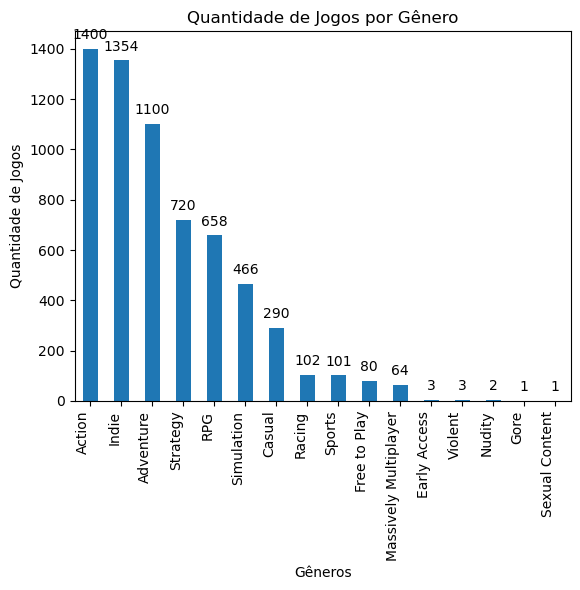

In [56]:
ax = contagem_generos.plot(kind='bar')
ax.set_xlabel('Gêneros')
ax.set_ylabel('Quantidade de Jogos')
ax.set_title('Quantidade de Jogos por Gênero')
plt.xticks(rotation=90, ha='right')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.show()

O *Gráfico 4.5* nos mostra a destribuição da quantidade de jogos por gênero, como ele temos em evidência que ação, indie e aventura são os gêneros de jogos mais presentes nos jogos da *Steam*.

### 4.3.3 Verificando a relação entre gênero e popularidade dos jogos

Aqui averiguaremos quais gêneros possuem os jogos mais populares, quais gêneros possuem os menos populares, quais gêneros possuem uma média maior de avaliações e coisas do tipo,

##### Gráfico 4.6

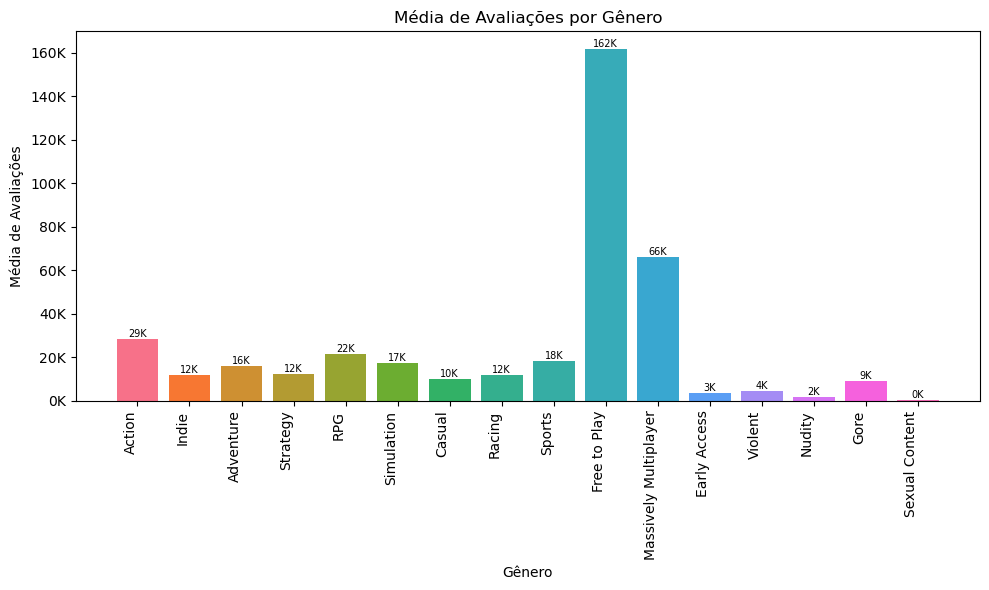

In [57]:
media_popularidade_por_genero = {}
for genero in contagem_generos.index:
    media = dadosNovos[dadosNovos['Generos'].str.contains(genero)]['Total_votos'].mean()
    media_popularidade_por_genero[genero] = media

df_popularidade_compradores = pd.DataFrame(list(media_popularidade_por_genero.items()), columns=['Gênero', 'Média_Popularidade'])

plt.figure(figsize=(10, 6))
cores = sns.color_palette("husl", n_colors=len(df_popularidade_compradores))
plt.bar(df_popularidade_compradores['Gênero'], df_popularidade_compradores['Média_Popularidade'], color=cores)
plt.xlabel('Gênero')
plt.ylabel('Média de Avaliações')
plt.title('Média de Avaliações por Gênero')
plt.xticks(rotation=90, ha='right')

formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}K'.format(x/1000))
ax = plt.gca()
ax.yaxis.set_major_formatter(formatter)

for i, media in enumerate(df_popularidade_compradores['Média_Popularidade']):
    plt.text(i, media, '{:,.0f}K'.format(media/1000), ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.show()

O *Gráfico 4.6* deixa bem evidente que jogos grátis e multiplayers possuem uma popularidade muito acima da média, sendo o que chamamos de "pontos fora da curva". Além disso também podemos notar que ação, RPG e esportes possuem uma popularidade maior que a maioria dos outros jogos.

### 4.3.4 Média de Compradores por gênero
Aqui inicialmente iremos remover jogos gratuitos do nosso dataset, afinal, nosso foco é saber o que leva alguém a comprar o jogo.

In [58]:
contagem_generos = contagem_generos.drop('Free to Play', errors='ignore')
dadosNovos = dadosNovos[dadosNovos['Free to Play'] == False]


Em seguida, iremos analisar quais gêneros de jogos possuem maiores médias de compradores através do *Gráfico 4.7*.

##### Gráfico 4.7

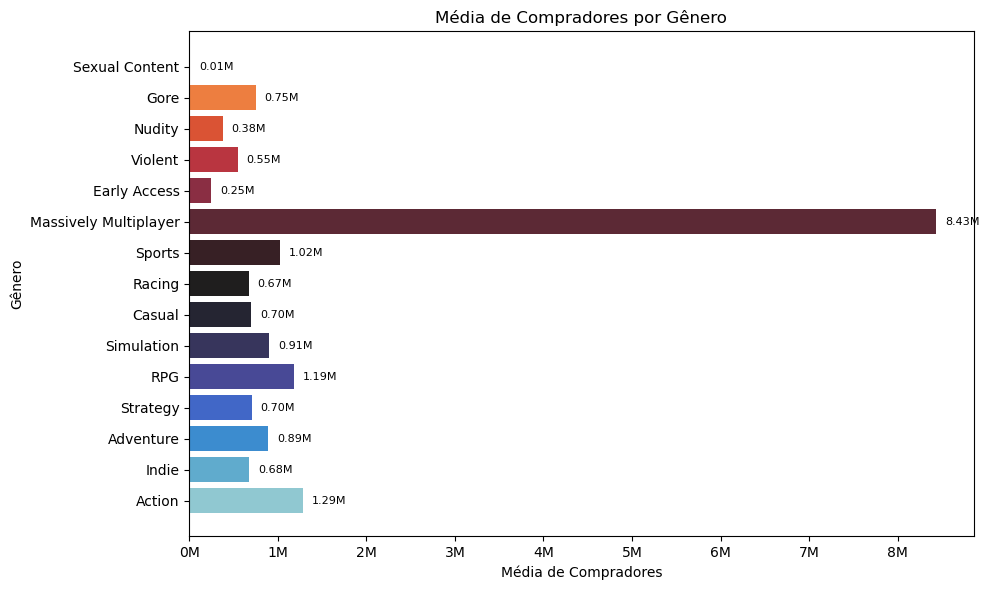

In [59]:
media_compradores_por_genero = {}
for genero in contagem_generos.index:
    media = dadosNovos[dadosNovos['Generos'].str.contains(genero)]['Quantidade_Compradores'].mean()
    media_compradores_por_genero[genero] = media

df_media_compradores = pd.DataFrame(list(media_compradores_por_genero.items()), columns=['Gênero', 'Média_Compradores'])

plt.figure(figsize=(10, 6))
cores = sns.color_palette("icefire", n_colors=len(df_media_compradores))
plt.barh(df_media_compradores['Gênero'], df_media_compradores['Média_Compradores'], color=cores)
plt.xlabel('Média de Compradores')
plt.ylabel('Gênero')
plt.title('Média de Compradores por Gênero')

formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f}B'.format(x/1e9) if x >= 1e9 else '{:.0f}M'.format(x/1e6))
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)

for i, media in enumerate(df_media_compradores['Média_Compradores']):
    plt.text(media + 0.1e9, i, '1B', va='center', fontsize=8) if media >= 1e9 else plt.text(media + 0.1e6, i, '{:,.2f}M'.format(media/1e6), va='center', fontsize=8)

plt.tight_layout()
plt.show()

É possível notar que, assim como a popularidade, jogos multiplayers também possui uma quantidade de compradores muito acima da média, indicando que nesse caso há uma relação entre sua popularidade e quantidade de compradores. Além disso, podemos perceber que jogos de ação, RPG e esportes seguem sendo os jogos que possuem médias acima dos demais jogos, estando apenas abaixo dos jogos multiplayers, indicando que realmente há alguma relação entre as variáveis *Quantidade_Compradores*, *Total_votos* e os gêneros dos jogos. 

#### 4.3.3.1 Analisando quais gêneros combinados vendem mais
Primeiramente iremos analisar uma matriz de correlação para vermos quais gêneros se relacionam mais entre si a partir do *Gráfico 4.6*

##### Gráfico 4.8

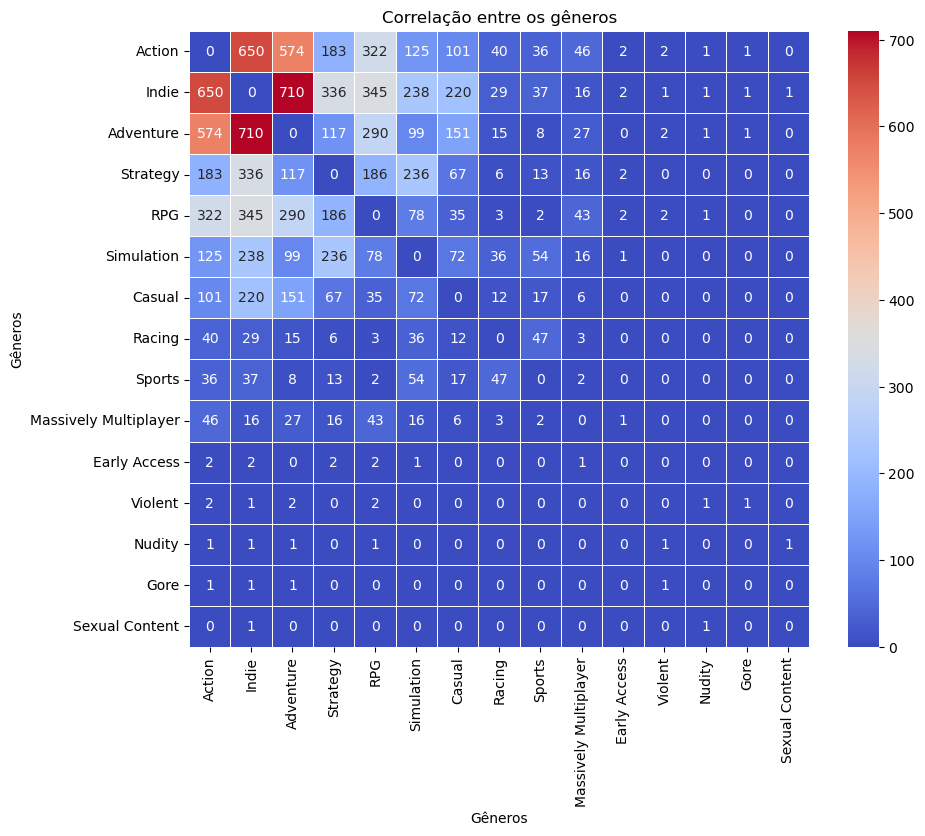

In [60]:
matriz_correlacao = pd.DataFrame(index=contagem_generos.index, columns=contagem_generos.index)

for gen1 in matriz_correlacao.index:
    for gen2 in matriz_correlacao.columns:
        if gen1 != gen2:
            correlacao = dados[dados['Generos'].str.contains(gen1) & dados['Generos'].str.contains(gen2)].shape[0]
            matriz_correlacao.loc[gen1, gen2] = correlacao

matriz_correlacao = matriz_correlacao.fillna(0).astype(int)

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5)
plt.title('Correlação entre os gêneros')
plt.xlabel('Gêneros')
plt.ylabel('Gêneros')
plt.show()

O *Gráfico 4.6* nos mostra que os gênero de ação, indie e aventura se relacionam muito entre si e com outros gêneros também. Também é válido dizer que gênero RPG, estratégia e simulação se relacionam bem com outros gêneros, mas não tanto quanto os anteriores mencionados.

A seguir, no *Gráfico 4.7*, veremos como as combinações de jogos impactam na quantidade de compradores:

##### Gráfico 4.9

C:\Users\bruns\AppData\Local\Temp\ipykernel_8408\1160516488.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row, col].set_yticklabels([par_generos[0] + ' & ' + par_generos[1]])


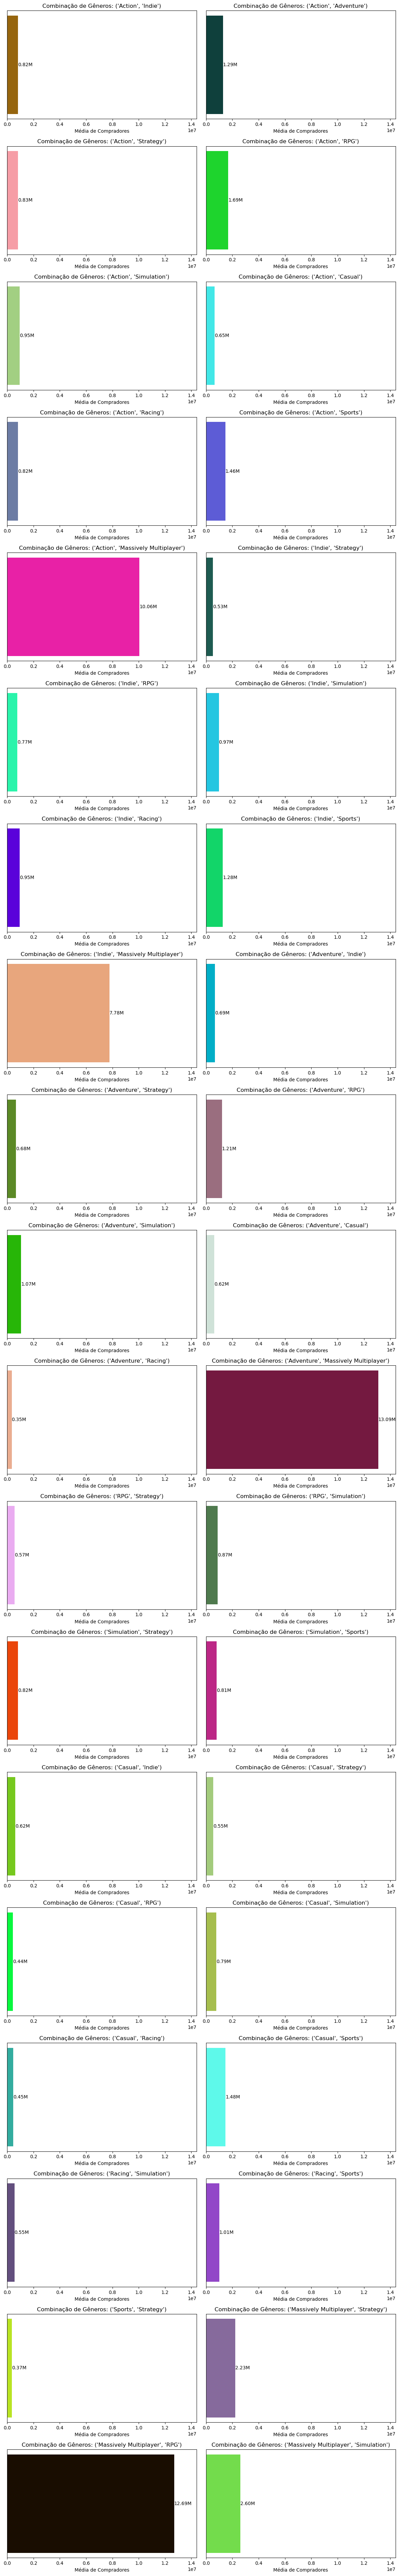

In [61]:
pares_generos_correlacao_acima_de_10 = [(gen1, gen2) for gen1 in matriz_correlacao.index
                                        for gen2 in matriz_correlacao.columns
                                        if gen1 < gen2 and matriz_correlacao.loc[gen1, gen2] > 10]

medias_compradores = []
for par_generos in pares_generos_correlacao_acima_de_10:
    dados_filtrados = dadosNovos[dadosNovos['Generos'].str.contains(par_generos[0]) & dadosNovos['Generos'].str.contains(par_generos[1])]
    media = dados_filtrados['Quantidade_Compradores'].mean()
    medias_compradores.append(media)

num_graficos = len(pares_generos_correlacao_acima_de_10)
num_linhas = (num_graficos + 1) // 2  
fig, axs = plt.subplots(num_linhas, 2, figsize=(12, num_linhas * 4))

colors = np.random.rand(num_graficos, 3) 

for i, (par_generos, color) in enumerate(zip(pares_generos_correlacao_acima_de_10, colors)):
    row = i // 2
    col = i % 2
    dados_filtrados = dadosNovos[dadosNovos['Generos'].str.contains(par_generos[0]) & dadosNovos['Generos'].str.contains(par_generos[1])]
    media = medias_compradores[i]
    axs[row, col].barh(par_generos[0] + ' & ' + par_generos[1], media, color=color)
    axs[row, col].set_xlabel('Média de Compradores')

    media_milhoes = media / 1e6
    axs[row, col].text(media, 0, f'{media_milhoes:.2f}M', ha='left', va='center')

    axs[row, col].set_title(f'Combinação de Gêneros: {par_generos}')
    axs[row, col].set_yticklabels([par_generos[0] + ' & ' + par_generos[1]])
    axs[row, col].set_yticks([])
    axs[row, col].set_xlim(0, max(medias_compradores) * 1.1)

if num_graficos % 2 != 0:
    axs[num_linhas - 1, 1].axis('off')

plt.tight_layout()
plt.show()

Como é possível observar no *Gráfico 4.9*, todos os jogos que se relacionam com o gênero Multiplayer tem mais chances de ter um alto índice de vendas. Agora, Vamos destacar as melhores combinaçãos de gêneros para vendas de jogos, sem contar conbinações que envolvam o gênero Multiplayer, pois já sabemos que ele é a melhor combinação possível, temos então:
* Ação e RPG com uma média de 1.69 milhões de vendas;
* Casual e Esportes com uma média de 1.48 milhões de vendas
* Aventura e Ação com uma média de 1.29 milhões de vendas;
* Indie e Esportes com uma média de 1.28 milhões de vendas;
* Aventura e RPG com uma média de 1.21 molhões de vendas;
* Simulação e Aventura com uma média de 1.07 milhões de vendas.

Em resumo, é perceptível que há jogos que atingem altas quantidade de compradores se combinados com gêneros específicos, enquanto tendem a ter baixos índices de compradores se estiverem juntos de outros gêneros.

#### 4.3.3.2 Regressão usando generos e preço em dólar como parâmentro
A usaremos a mesma regressão do *Subtópico 4.2.3* em conjunto com a análise feita sobre como cada gênero influencia na quantidade de compradores dos jogos, além disso adicionaremos o preço em dólar dos jogos ao modelo. 

In [62]:
outliers = dadosNovos[((dadosNovos['Total_votos'] - dadosNovos['Total_votos'].mean()) / dadosNovos['Total_votos'].std()).abs() > 2]
dados_sem_outliers = dadosNovos.drop(outliers.index)

scaler = StandardScaler()
predictors = ['Total_votos', 'Pico_jogadores', 'Tempo_medio_sempre', 'Preço_Dolar'] + lista_generos 
outcome = 'Quantidade_Compradores'
dados_sem_outliers[predictors] = scaler.fit_transform(dados_sem_outliers[predictors])

X_train, X_test, y_train, y_test = train_test_split(dados_sem_outliers[predictors], dados_sem_outliers[outcome], test_size=0.5, random_state=42)

dados_lm = LinearRegression()
dados_lm.fit(X_train, y_train)

jogos_exist = dados_sem_outliers.sample(n=10, random_state=3)
predito = dados_lm.predict(jogos_exist[predictors])
jogos_exist['Quantidade_Compradores_Predito'] = predito
print("Resultado do teste do modelo:")
print(jogos_exist[[outcome, 'Quantidade_Compradores_Predito']].applymap(lambda x: "{:,.0f}".format(x)))

fitted = dados_lm.predict(dados_sem_outliers[predictors])
RMSE = np.sqrt(mean_squared_error(dados_sem_outliers[outcome], fitted))
r2 = r2_score(dados_sem_outliers[outcome], fitted)
print(f'\nRoot Mean Square Error (RMSE) (sem outliers): {RMSE:,.2f}')
print(f'Coefficient of determination (R²) (sem outliers): {r2:.4f}')

accuracy = 1 - (np.mean(np.abs(predito - jogos_exist[outcome])) / np.mean(jogos_exist[outcome]))
print(f'\nAcurácia do modelo: {accuracy:.2%}')

Resultado do teste do modelo:
      Quantidade_Compradores Quantidade_Compradores_Predito
28267                350,000                        656,269
3071                 150,000                        113,131
29804                750,000                        185,281
16436              1,500,000                      1,399,916
43147                750,000                        630,832
35013                750,000                        960,613
56331                350,000                        329,105
8709               3,500,000                      2,122,030
56795                 35,000                        147,114
21423                750,000                        864,984

Root Mean Square Error (RMSE) (sem outliers): 870,300.06
Coefficient of determination (R²) (sem outliers): 0.5203

Acurácia do modelo: 66.64%


Em comparação com o modelo anterior, do *Subtópico 4.2.3*, podemo tira as seguintes conclusões:

* RMSE - O antigo modelo tem um RMSE muito maior (1,708,088.49) em comparação com o novo (870,300.06). Isso significa que as previsões do antigo modelo estão mais distantes dos valores reais em média do que as do novo modelo que adiciona os gêneros como variáveis independentes. Portanto, quando se adiciona os gêneros dos jogos na equação, acaba-se tendo uma melhor capacidade de prever com precisão a quantidade de compradores.

* R² - O novo modelo tem um R² mais alto (0.5203) em comparação com o antigo (0.4304). Isso indica que o novo modelo explica uma maior proporção da variabilidade na quantidade de compradores, mostrando novamente a importância de adicionar os gêneros dos jogos ao modelo.

* Acurácia - O novo modelo também tem uma acurácia ligeiramente maior (66.64%) em comparação com o antigo (61.45%). Isso sugere que o novo modelo tem uma precisão um pouco melhor em prever a quantidade de compradores.

Em resumo, o novo modelo parece ser mais preciso e explicativo em relação à quantidade de compradores do que o antigo modelo, mesmo que não possua uma acurácia tão diferente do mesmo.

##### 5.0 Gráfico de dispersão com linha de Regressão Linear

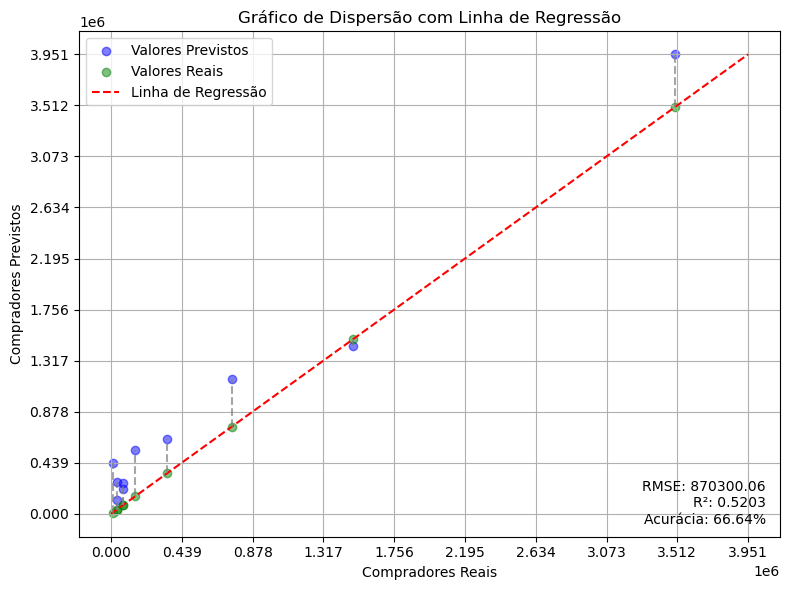

In [63]:
fitted = dados_lm.predict(dados_sem_outliers[predictors])
primeiros_10 = dados_sem_outliers.head(10)
max_x = max(primeiros_10[outcome].max(), fitted[:10].max())

plt.figure(figsize=(8, 6))
plt.scatter(primeiros_10[outcome], fitted[:10], color='blue', label='Valores Previstos', alpha=0.5)
plt.scatter(primeiros_10[outcome], primeiros_10[outcome], color='green', label='Valores Reais', alpha=0.5)
plt.plot([1, max_x], [1, max_x], color='red', linestyle='--', label='Linha de Regressão')
for i in range(len(primeiros_10)):
    plt.plot([primeiros_10[outcome].iloc[i], primeiros_10[outcome].iloc[i]], [primeiros_10[outcome].iloc[i], fitted[i]], '--', color='gray', alpha=0.7)
plt.xlabel('Compradores Reais')
plt.ylabel('Compradores Previstos')
plt.title('Gráfico de Dispersão com Linha de Regressão')
plt.legend()
plt.grid(True)
plt.xticks(np.linspace(1, max_x, 10))
plt.yticks(np.linspace(1, max_x, 10))
plt.text(0.98, 0.02, f'RMSE: {RMSE:.2f}\nR²: {r2:.4f}\nAcurácia: {accuracy:.2%}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='right')
plt.tight_layout()
plt.show()


O *Gráfico 5.0* demonstra graficamente um teste realizado para verificar a precisão do modelo com 10 jogos aleatórios, analisando-o podemos notar que:

* Os pontos azuis (valores previstos) e os pontos verdes (valores reais) estão bem alinhados, demonstrando haver uma alta precisão dos valores no modelo. Ou seja, quando os valores reais aumentam, os valores previstos também aumentam na mesma proporção, e vice-versa.

* Os pontos azuis e verdes estão próximos da Linha de Regressão, indicando que o modelo está prevendo de forma precisa e está capturando bem a relação entre as variáveis independentes e dependentes.

* os pontos cinzas estão uniformemente distribuídos em torno da linha de regressão, significando que o modelo está fazendo previsões consistentes, sem um viés sistemático de subestimar ou superestimar os valores, exceto por alguns casos excepcionais.

Resumidamente, podemos dizer que o modelo possuí uma alta precisão, captura bem a relação entre as variavéis e faz previsões consistentes, desde que não envolva outliers ou casos excepcionais.

# 5. Conclusão
Vamos separar a conclusão por partes importantes, demonstrando cada aprendizado que obtivemos em nossas análises e ao final daremos nosso veredito sobre a visão geral do nosso trabalho.

## 5.1 O que aprendemos nas análises exploratórias.
Aqui veremos o que foi possível tirar de aprendizado de nossas análises exploratórias.

### 5.1.1 Analise por desenvolvedores
Aprendemos que apenas empresas famosas, ou mais antigas no mercado, como a *Valve* e *Ubisoft* se arriscaram a produzir mais de 10 jogos, indicando que apenas grandes empresas possuem capacidade e estrutura para tal. Porém, estas mesmas empresas não estão presente no *Ranking das empresas com melhores notas Metacritic*, indicando que, talvez, produzir menos jogos faz com que as empresas consigam focar em produzir jogos melhores, do que fazer vários em sequência.

### 5.1.2 Analise por data de lançamento
Vimos que o lançamento de jogos por anos começou a ter um crescimento exponencial a partir do ano de 2011, mas que passou a decair em 2020, demonstrando que a pandemia acabou impactando o lançamento dos jogos durante este periodo. Também percebemos que os jogos mais populares estão destribuidos nos anos de 1998, 2000, 2004 e 2012, podendo esses ser os anos com lançamentos dos jogos mais marcantes para indústria.

### 5.1.3 Medidas de centralidade e dispersão dos jogos
Resumidamente podemos dizer que: 
* O preço médio dos jogos é de $16,43 dólares, enquanto possuí um desvio padrão de 12.52, indicando que o preço dos jogos têm uma grande variabilidade em comparação à média;
* O pico de jogadores médio de um jogo é de 1.976, tendo uma variância de 26.523 que sugere haver uma grande variabilidade nos picos de jogadores entre os jogos;
* 74,70 é a nota Metacritic média dos jogos e sua variância e de 9,57, indicando haver variabilidade considerável em relação à média.


### 5.1.4 Analisando dublagem dos jogos
Aprendemos que jogos dublados são muito mais populares que jogos sem dublagem e também tendem a serem mais adiquiridos pelos usuários da *Steam*. Também observamos que inglês, alemão e francês são os idiomas mais utilizados para dublar jogos, e que português brasileiro está presente no *top 10 idiomas mais dublados*, indicando que as empresas de jogos valorizam nosso mercado de games. Além disso vimos que as dublagens para PT-BR começaram a surgir mais após o lançamento de *The Witcher 2: Assassins of Kings - Enhanced Edition*, que possuía dublagem para PT-BR e acabou sendo bastante popular na época.

## 5.2 O que foi possível entender analisando as relações entre variáveis
Agora veremos o que conseguimos captar de informações através de nossa análise de relações entre variáveis.

### 5.2.1 Visão geral
Percebemos que muitas variáveis se relacionavam bem entre si, indicando serem variáveis úteis para análises futuras.

### 5.2.2 Relação entre pico de jogadores e total de avaliações recebidas
Usando o método de Análise Linear, conseguimos notar que os dados pareciam estar bem destribuidos pela reta do modelo. Apenas com os metódos *Pearson*, *Spearman* e *Kendall* que tivemos certeza que havia de fato uma relação entre as variáveis, não só isso, como também vimos que se trata de uma correlação positiva, ou seja, quando um valor aumenta, o outro tenda a aumentar junto.

### 5.2.3 Relação entre tempo médio de jogatina e pico de jogadores
Utilizando-se do método de Análise Linear novamente, mal conseguimos perceber a destribuição dos dados seguindo uma reta linear, isso por causa dos dados estarem muito dispersos. Tentamos utilizar os métodos *Pearson*, *Spearman* e *Kendall* e vimos que todos os resultados indicavam haver correlações fracas entre as variáveis, exceto pelo método *Spearman*, que sugeria que quanto maior o pico de jogadores de um jogo, maior será seu tempo médio de jogatina entre os players.

### 5.2.4 Relação entre a quantidade de Avaliações positivas e negativas
O método de Análise linear deixaca explicito haver uma boa destribuição dos dados seguindo a reta linear do modelo. Nesse caso os métodos *Pearson*, *Spearman* e *Kendall* só serviram para confirmar o que já era óbvio, que as variáveis tendem a aumentar e diminuir juntas.

Indo mais a fundo na análise podemos vê que os jogos com mais quantidades de avaliações positivas, ou negativas, não necessariamente são os jogos com maiores porcentagens de avaliações positivas, ou negativas, e vice versa. Também notamos haver uma relação entre a nota Metacrit e a porcentagem de avaliações positivas dos jogos, indicando que a nota dos críticos se assemelhavam à nota dos players.

## 5.3 O que aprendemos com nossos modelos de Regressões Lineares e Múltiplas
Por fim veremos o que foi possível adquirir de conhecimento com nossos modelos de Regressão.

## 5.3.1 Regressão Linear entre porcentagem de avaliações positivas e nota Metacritic
Observamos que o modelo indica haver uma relação entre a nota do Metacritic e a porcentagem de avaliações positivas, onde um aumento na nota do Metacritic está associado a um aumento na porcentagem de avaliações positivas, e vice-versa. Entretanto há uma quantidade significativa de variabilidade que o modelo não consegue explicar, demontrando haver uma grande dispersão na destribuição dos dados na reta.


### 5.3.2 Regressão Múltipla para tentar predizer a quantidade de compradores de um jogo
Utilizando-se das variáveis *Total_voto*, *Pixo_jogadores* e *Tempo_medio_sempre* como variáveis independentes do modelo, foi possível, incialmente, perceber que cada variável independente contribui para prever a quantidade da variável dependente *Quantidade_Compradores*. A avaliação do modelo sugeriu haver um desempenho razoável do mesmo em explicar parte da variável dependente, mas que ainda havia espaço para melhorias.

As melhorias aplicadas foram a remorsão de outliers do modelo, divisão dos dados e treinamento do modelo. Essas melhorias nos garantiu uma melhoria no desempenho do modelo na previsão na quantidade de compradores, explicando apenas uma parte da variação nos dados. Entretanto, não foi suficiente, pois ainda havia um erro considerável nas previsões.

### 5.3.3 Avaliando se é possível melhorar a Regressão Múltipla utilizando os gêneros dos jogos e seu preço em dólar como variáveis
Inicialmente vimos a destribuição dos jogos por gêneros e notamos que os gêneros de ação, indie e aventura são os que mais possuem jogos na *Steam*. Logo em seguida, verificamos se havia relação entre a popularidade dos jogos e seus gêneros e ficou evidente quão populares são os jogos gratuitos e multiplayers quando comparado com os outros.

Após tudo isso, fomos analisar a média de compradores que cada jogo possuí e, aqui removemos os jogos gratuitos da análise por motivos óbvios, novamente vimos que jogos multiplayers possuem uma adesão maior dos jogadores, possuindo mais que o triplo da média geral de compradores por gênero. Em seguida, fizemos uma breve análise da correlação entre os gêneros e como essas combinações impactam na quantidade de compradores dos jogos, nesta análise percebemos que não importa o gênero, se ele estiver em um jogo multiplayer, ele tenderá a ter altos índices de compradores.

Por fim, adicionamos os gêneros e o preço em dólar dos games como variáveis independentes ao modelo criado no *Subtópico 4.2.3* e tivemos melhorias significativas nos resultados dos teste RMSE e R², indicando que nosso modelo atual é mais preciso e explicativo em relação à quantidade de compradores do antigo modelo, demonstrando que os gêneros dos jogos e seu preço em sólar fizeram bastante diferença na predição dos valores e no resultado das análises do modelo.

## 5.4 Conclusão final
Podemos concluir que é sim possível prever a quantidade de compradores e a popularidade dos jogos se utilizarmos as variáveis e estratégias certas para a análise, por mais que a predição não seja 100% precisa, ela chega a valores aproximados na maioria dos casos, exceto pelos outliers. Também notamos que há espaço para diversas melhorias no modelo, mas que devido ao tempo curto não foram possíveis de serem implementadas, uma delas seria adicionar uma variável de jogos dublados e sem dublagens ao modelo, afinal, já havia sido visto que jogos dublados tendiam a ter mais compradores.
